<a href="https://colab.research.google.com/github/DTomasVr/Checkers_CSP/blob/main/TP_topicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!python -m pip install ortools -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 13.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.26.1 which is incompatible.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-firestore 2.16.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,

In [ ]:
from ortools.sat.python import cp_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Resolución con CSP

In [ ]:
class CheckersGame:
    def __init__(self, board=None, player_turn=1):
        self.size = 8
        self.board = np.zeros((self.size, self.size), dtype=int) if board is None else board.copy()
        self.player_turn = player_turn
        if board is None:
            self.setup_board()

    def setup_board(self):
        for row in range(3):
            for col in range(self.size):
                if (row + col) % 2 == 1:
                    self.board[row][col] = -1  # Fichas negras
        for row in range(5, 8):
            for col in range(self.size):
                if (row + col) % 2 == 1:
                    self.board[row][col] = 1  # Fichas blancas

    # def print_board(self):
    #     symbols = {0: '.', 1: 'w', 2: 'W', -1: 'b', -2: 'B'}
    #     for row in self.board:
    #         print(' '.join([symbols[cell] for cell in row]))
    #     print()
    def print_board(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        board_size = len(self.board)

        colors = ['#F0D9B5', '#B58863']
        for row in range(board_size):
            for col in range(board_size):
                color = colors[(row + col) % 2]
                rect = patches.Rectangle((col, board_size - row - 1), 1, 1, facecolor=color)
                ax.add_patch(rect)

                piece = self.board[row][col]
                if piece == 1 or piece == 2:
                    circle = patches.Circle((col + 0.5, board_size - row - 1 + 0.5), 0.4, facecolor='white', edgecolor='black')
                    ax.add_patch(circle)
                    if piece == 2:
                        ax.text(col + 0.5, board_size - row - 1 + 0.5, 'W', fontsize=20, ha='center', va='center', color='black')
                elif piece == -1 or piece == -2:  #s
                    circle = patches.Circle((col + 0.5, board_size - row - 1 + 0.5), 0.4, facecolor='black', edgecolor='black')
                    ax.add_patch(circle)
                    if piece == -2:  # Dama negra
                        ax.text(col + 0.5, board_size - row - 1 + 0.5, 'B', fontsize=20, ha='center', va='center', color='white')

        ax.set_xlim(0, board_size)
        ax.set_ylim(0, board_size)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        plt.show()
    def is_game_over(self):
        return not np.any(self.board == self.player_turn) and not np.any(self.board == 2 * self.player_turn)



In [ ]:
def find_best_move(game):
    model = cp_model.CpModel()

    size = game.size
    board = game.board
    player = game.player_turn

    move_vars = []
    priorities = []

    move_id = 0
    for row in range(size):
        for col in range(size):
            piece = board[row][col]
            if piece * player > 0:
                directions = []
                if abs(piece) == 1:
                    # Ficha común
                    directions = [(-1, -1), (-1, 1)] if player == 1 else [(1, -1), (1, 1)]
                else:
                    # Dama
                    directions = [(-1, -1), (-1, 1), (1, -1), (1, 1)]

                for dr, dc in directions:
                    new_row = row + dr
                    new_col = col + dc

                    # Movimiento simple
                    if 0 <= new_row < size and 0 <= new_col < size and board[new_row][new_col] == 0:
                        # Prioridad 3: Mover una ficha hacia adelante
                        move_vars.append(((row, col), (new_row, new_col)))
                        val = random.randint(3,10)
                        priorities.append(val)

                    # Captura
                    if 0 <= new_row < size and 0 <= new_col < size and board[new_row][new_col] * player < 0:
                        jump_row = new_row + dr
                        jump_col = new_col + dc
                        if 0 <= jump_row < size and 0 <= jump_col < size and board[jump_row][jump_col] == 0:
                            # Prioridad 2: Comer una ficha común del oponente
                            move_vars.append(((row, col), (jump_row, jump_col)))
                            priorities.append(2)

                # Verificar si puede coronar
                if (player == 1 and row == 1) or (player == -1 and row == size - 2):
                    for dr, dc in directions:
                        new_row = row + dr
                        new_col = col + dc
                        if 0 <= new_row < size and 0 <= new_col < size and board[new_row][new_col] == 0:
                            # Prioridad 1: Conseguir una reina
                            move_vars.append(((row, col), (new_row, new_col)))
                            priorities.append(1)

    # Verificar si hay movimientos posibles
    if not move_vars:
        print("No hay movimientos posibles para el jugador", 'blanco' if player == 1 else 'negro')
        return None

    # Variables de decisión en el modelo CSP
    selected_move = model.NewIntVar(0, len(move_vars) - 1, 'selected_move')
    priority_vars = []
    for i in range(len(move_vars)):
        is_selected = model.NewBoolVar(f'is_selected_{i}')
        model.Add(selected_move == i).OnlyEnforceIf(is_selected)
        model.Add(selected_move != i).OnlyEnforceIf(is_selected.Not())
        priority_vars.append(is_selected * priorities[i])

    # Función objetivo: Minimizar la prioridad
    total_priority = sum(priority_vars)
    model.Minimize(total_priority)

    # Resolver el modelo
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        idx = solver.Value(selected_move)
        move = {
            'from': move_vars[idx][0],
            'to': move_vars[idx][1],
            'priority': priorities[idx]
        }
        return move
    else:
        print("No se encontró un movimiento válido.")
        return None



Turno 0 del jugador: blanco


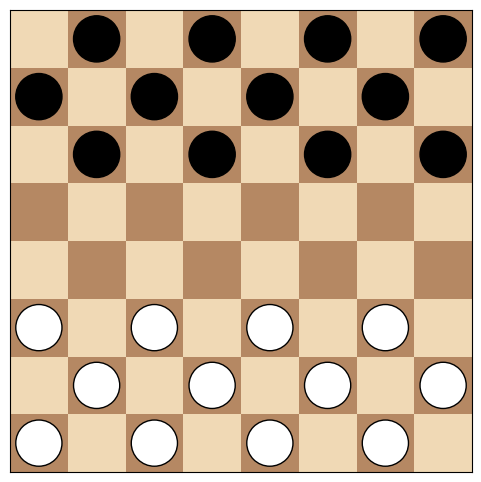

Movimiento de blanco desde (5, 2) a (4, 3) con prioridad 3

Turno 1 del jugador: negro


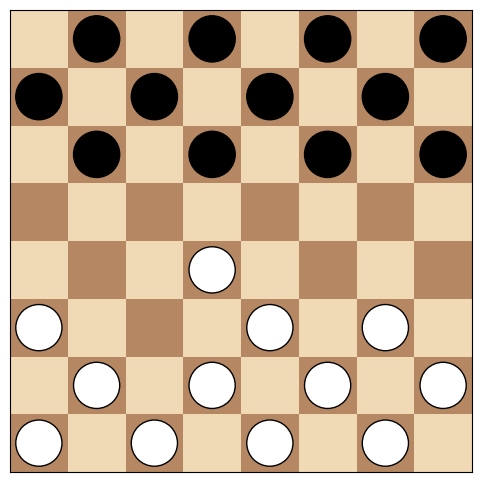

Movimiento de negro desde (2, 1) a (3, 2) con prioridad 4

Turno 2 del jugador: blanco


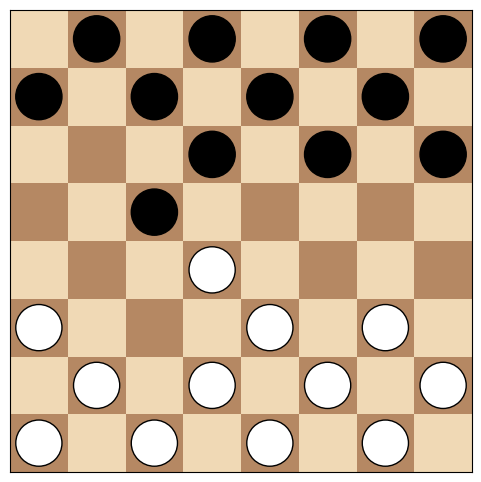

Movimiento de blanco desde (4, 3) a (2, 1) con prioridad 2

Turno 3 del jugador: negro


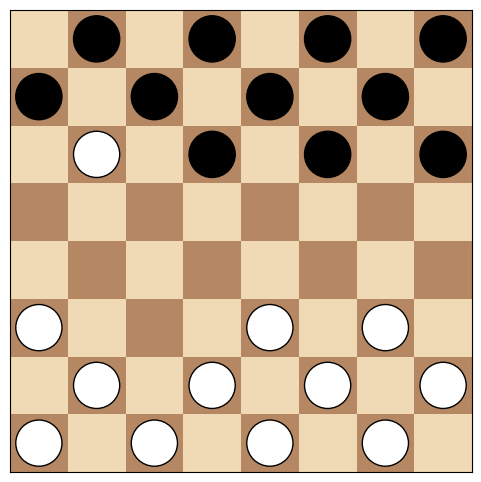

Movimiento de negro desde (1, 2) a (3, 0) con prioridad 2

Turno 4 del jugador: blanco


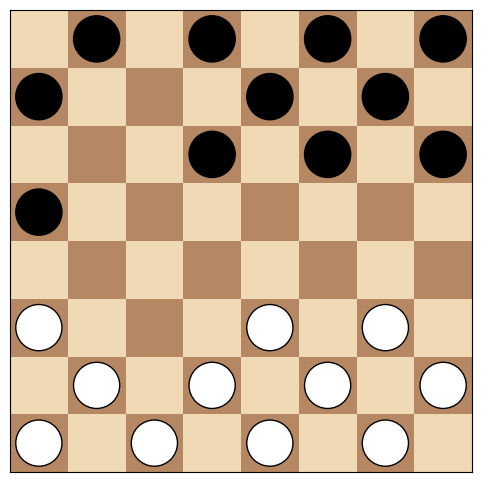

Movimiento de blanco desde (6, 3) a (5, 2) con prioridad 3

Turno 5 del jugador: negro


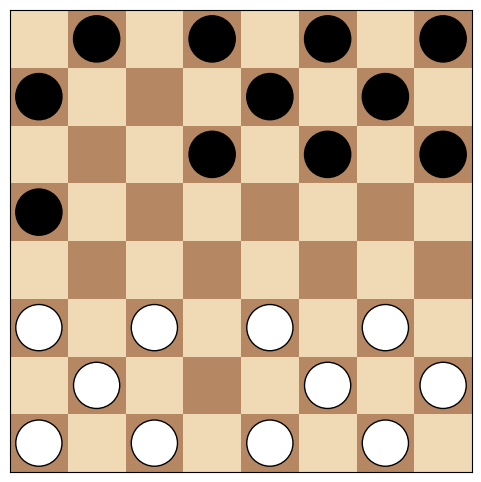

Movimiento de negro desde (0, 1) a (1, 2) con prioridad 3

Turno 6 del jugador: blanco


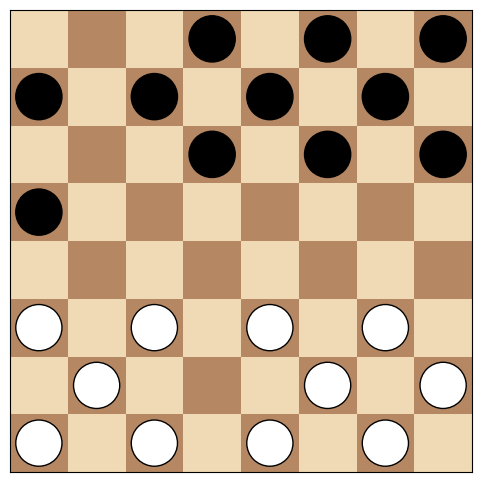

Movimiento de blanco desde (5, 4) a (4, 5) con prioridad 3

Turno 7 del jugador: negro


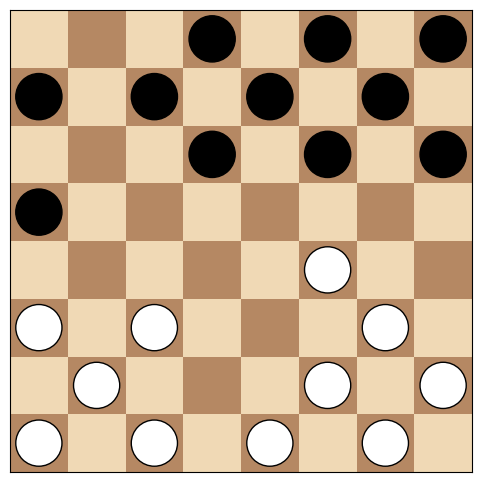

Movimiento de negro desde (2, 7) a (3, 6) con prioridad 3

Turno 8 del jugador: blanco


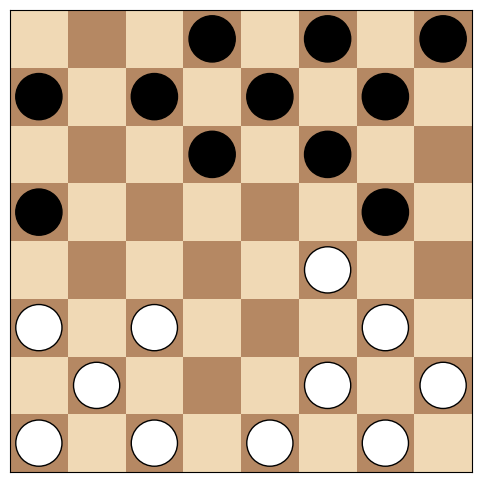

Movimiento de blanco desde (4, 5) a (2, 7) con prioridad 2

Turno 9 del jugador: negro


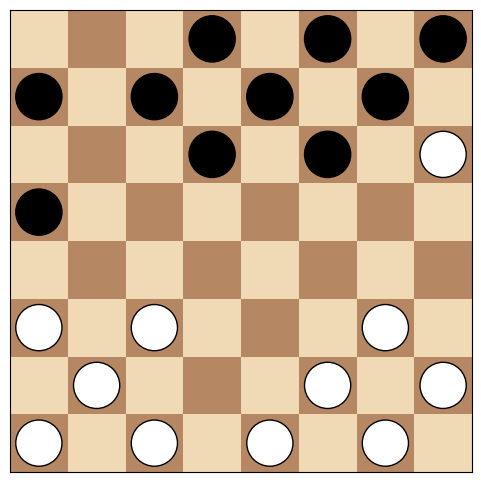

Movimiento de negro desde (2, 3) a (3, 2) con prioridad 3

Turno 10 del jugador: blanco


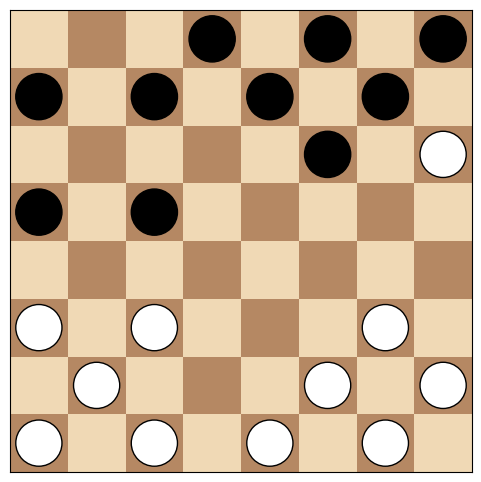

Movimiento de blanco desde (5, 6) a (4, 7) con prioridad 3

Turno 11 del jugador: negro


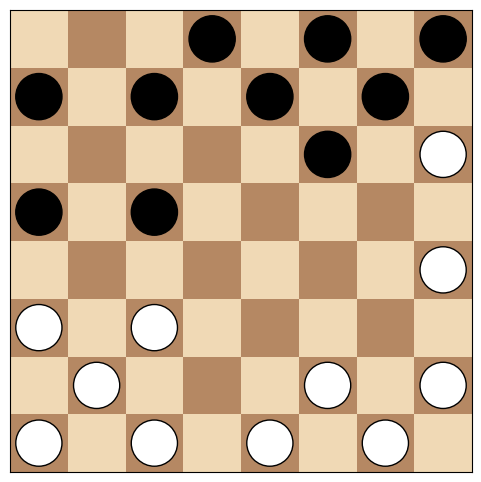

Movimiento de negro desde (3, 2) a (4, 3) con prioridad 3

Turno 12 del jugador: blanco


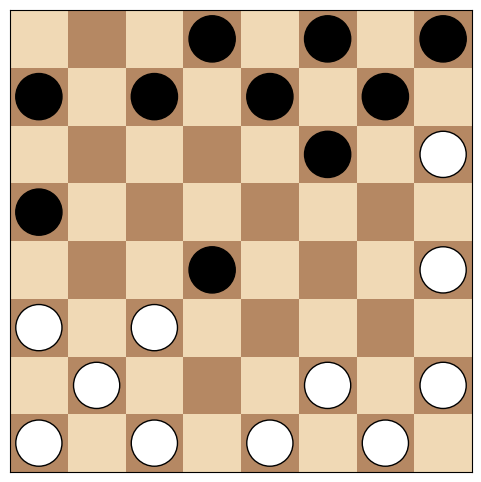

Movimiento de blanco desde (5, 2) a (3, 4) con prioridad 2

Turno 13 del jugador: negro


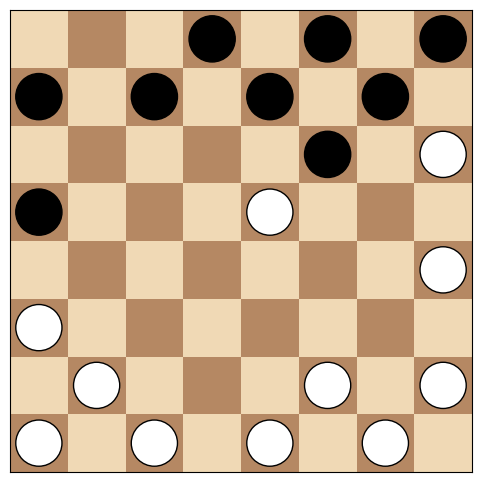

Movimiento de negro desde (2, 5) a (4, 3) con prioridad 2

Turno 14 del jugador: blanco


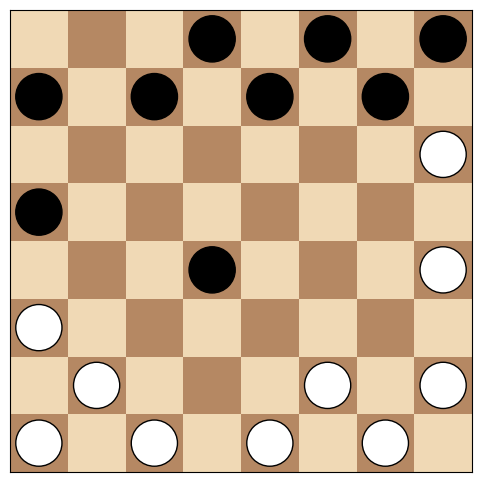

Movimiento de blanco desde (7, 4) a (6, 3) con prioridad 3

Turno 15 del jugador: negro


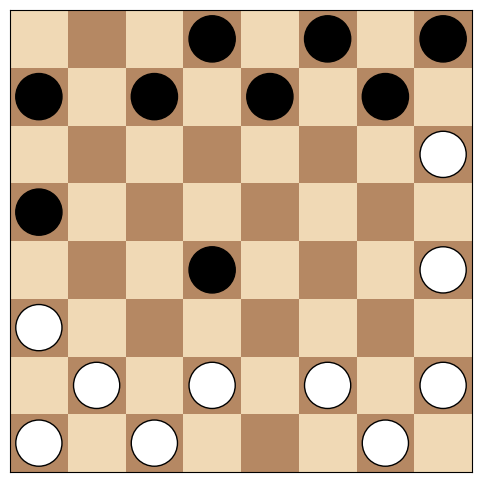

Movimiento de negro desde (4, 3) a (5, 4) con prioridad 3

Turno 16 del jugador: blanco


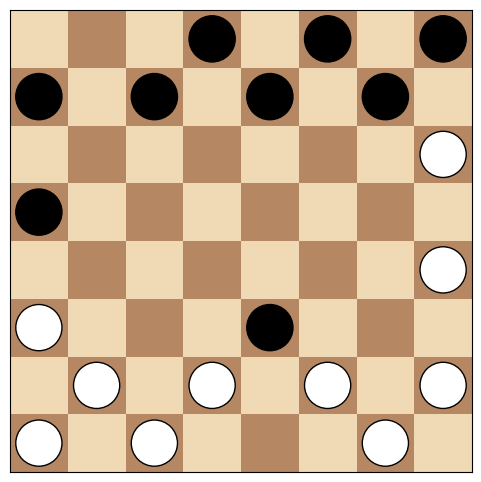

Movimiento de blanco desde (6, 5) a (4, 3) con prioridad 2

Turno 17 del jugador: negro


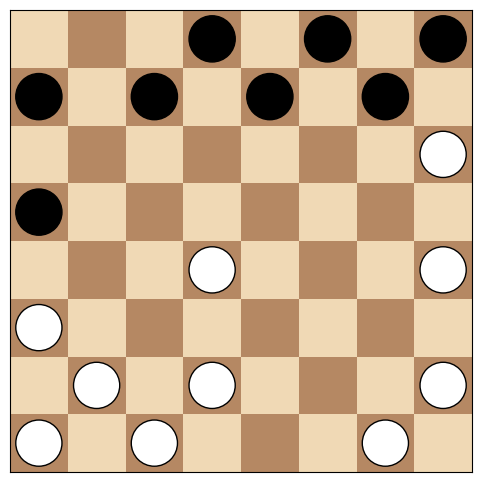

Movimiento de negro desde (3, 0) a (4, 1) con prioridad 3

Turno 18 del jugador: blanco


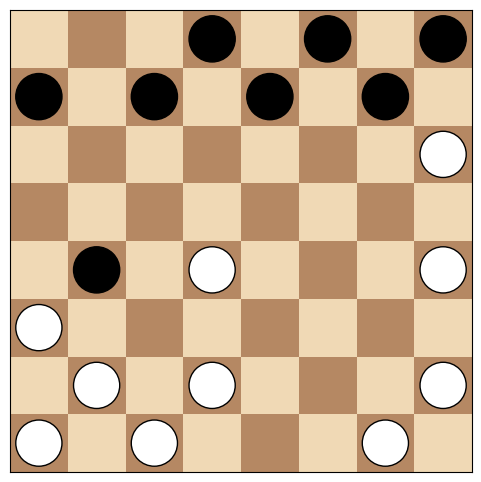

Movimiento de blanco desde (5, 0) a (3, 2) con prioridad 2

Turno 19 del jugador: negro


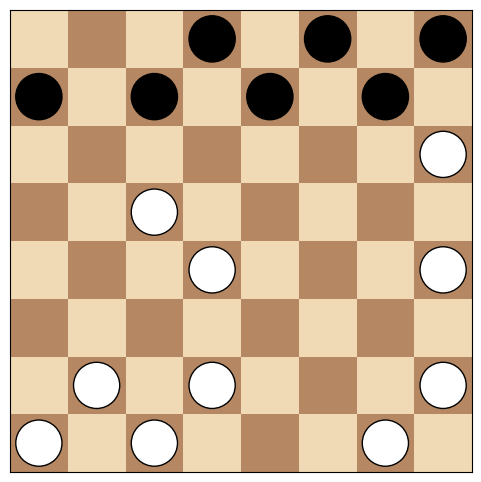

Movimiento de negro desde (1, 0) a (2, 1) con prioridad 3

Turno 20 del jugador: blanco


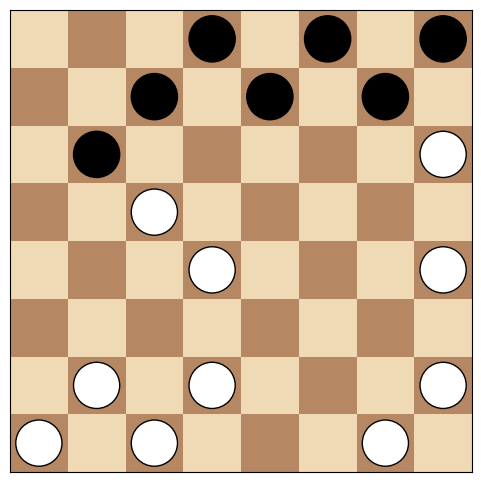

Movimiento de blanco desde (3, 2) a (1, 0) con prioridad 2

Turno 21 del jugador: negro


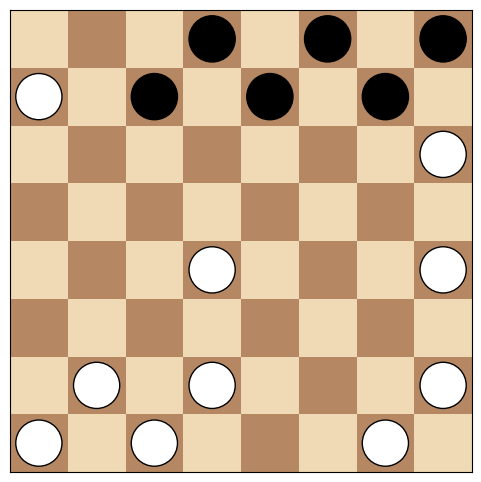

Movimiento de negro desde (1, 2) a (2, 3) con prioridad 4

Turno 22 del jugador: blanco


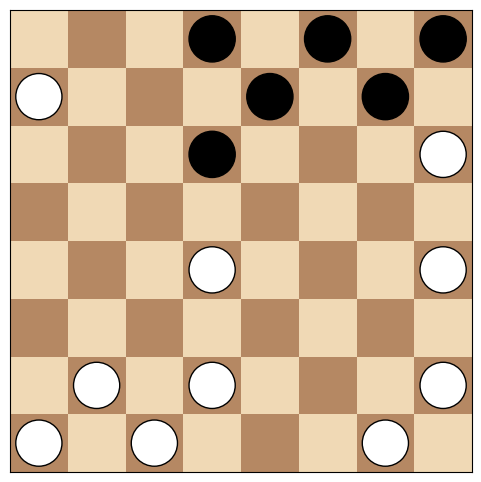

Movimiento de blanco desde (1, 0) a (0, 1) con prioridad 1

Turno 23 del jugador: negro


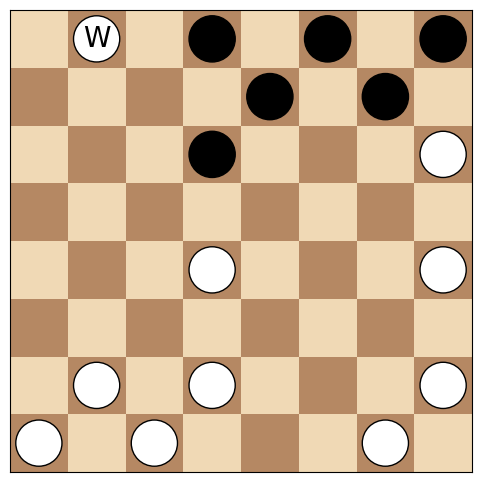

Movimiento de negro desde (2, 3) a (3, 2) con prioridad 4

Turno 24 del jugador: blanco


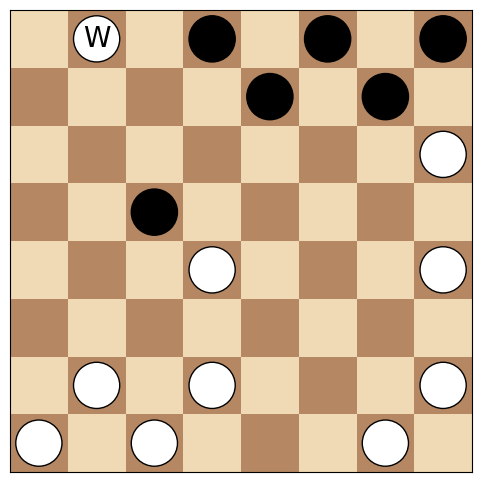

Movimiento de blanco desde (4, 3) a (2, 1) con prioridad 2

Turno 25 del jugador: negro


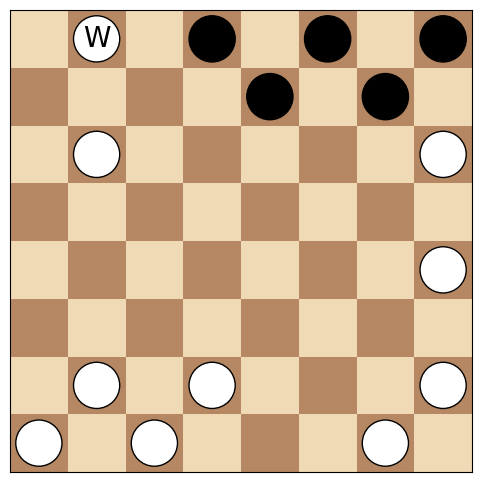

Movimiento de negro desde (1, 4) a (2, 5) con prioridad 5

Turno 26 del jugador: blanco


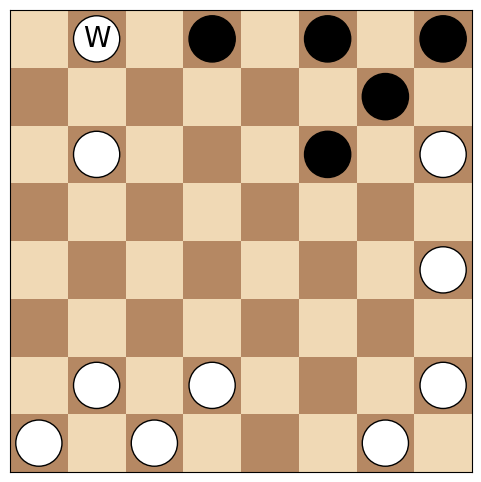

Movimiento de blanco desde (6, 7) a (5, 6) con prioridad 3

Turno 27 del jugador: negro


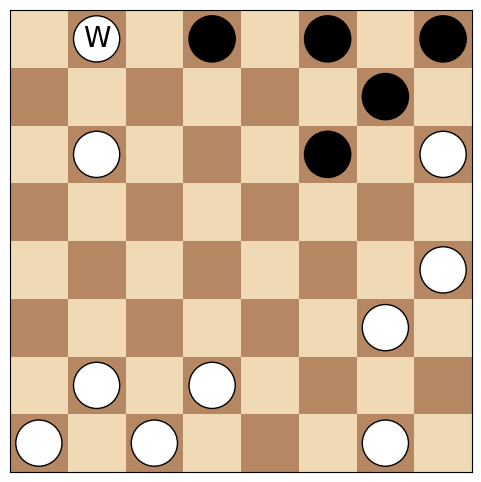

Movimiento de negro desde (2, 5) a (3, 6) con prioridad 3

Turno 28 del jugador: blanco


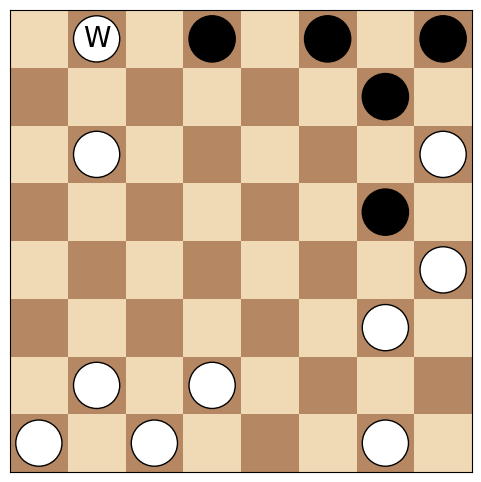

Movimiento de blanco desde (4, 7) a (2, 5) con prioridad 2

Turno 29 del jugador: negro


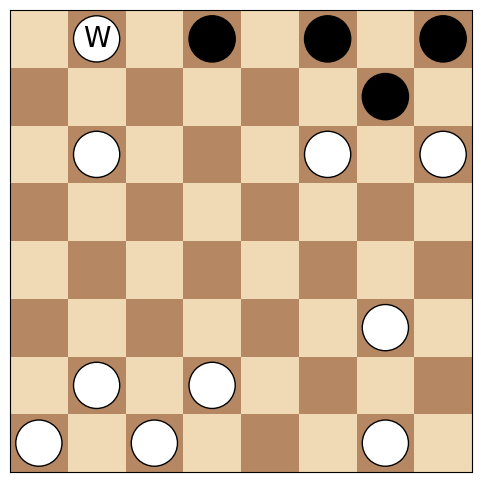

Movimiento de negro desde (1, 6) a (3, 4) con prioridad 2

Turno 30 del jugador: blanco


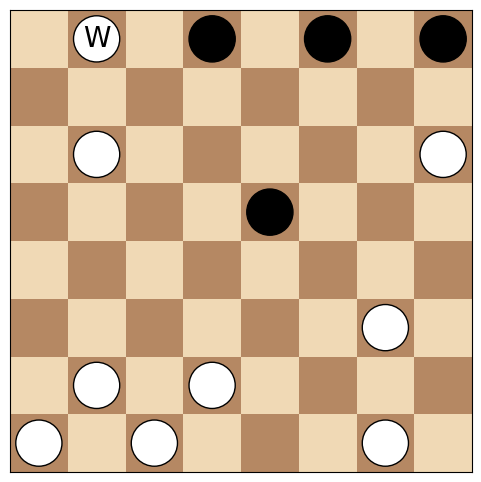

Movimiento de blanco desde (6, 3) a (5, 4) con prioridad 3

Turno 31 del jugador: negro


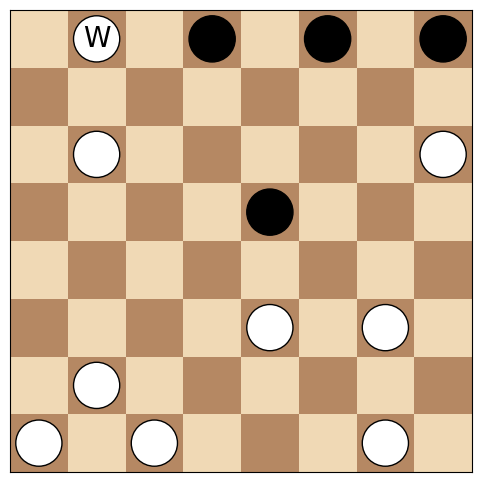

Movimiento de negro desde (0, 5) a (1, 4) con prioridad 3

Turno 32 del jugador: blanco


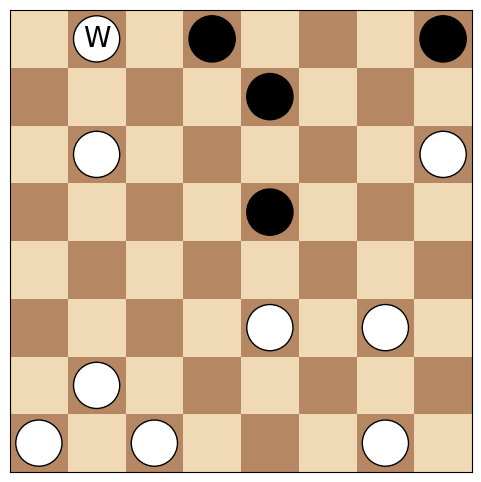

Movimiento de blanco desde (2, 1) a (1, 2) con prioridad 3

Turno 33 del jugador: negro


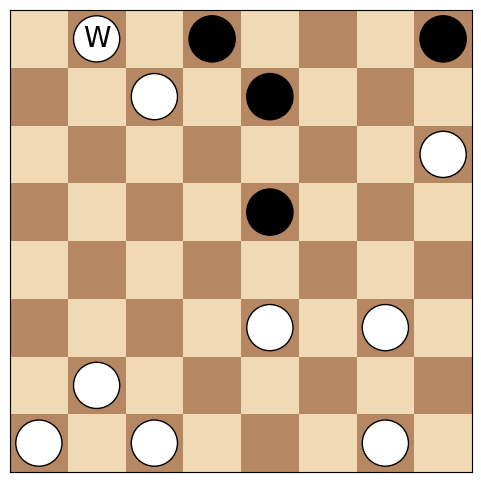

Movimiento de negro desde (0, 3) a (2, 1) con prioridad 2

Turno 34 del jugador: blanco


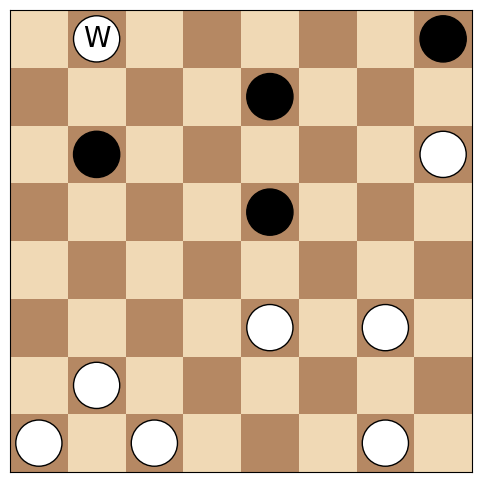

Movimiento de blanco desde (5, 4) a (4, 5) con prioridad 3

Turno 35 del jugador: negro


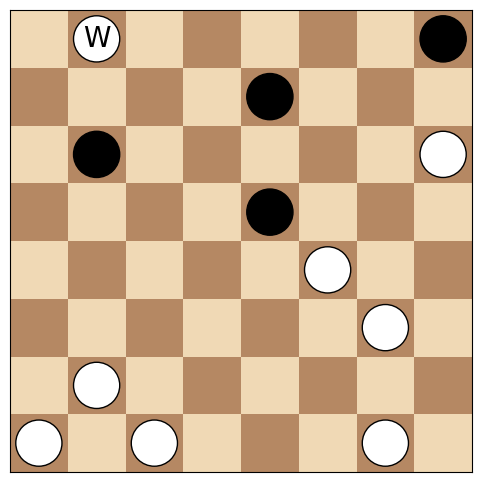

Movimiento de negro desde (3, 4) a (4, 3) con prioridad 3

Turno 36 del jugador: blanco


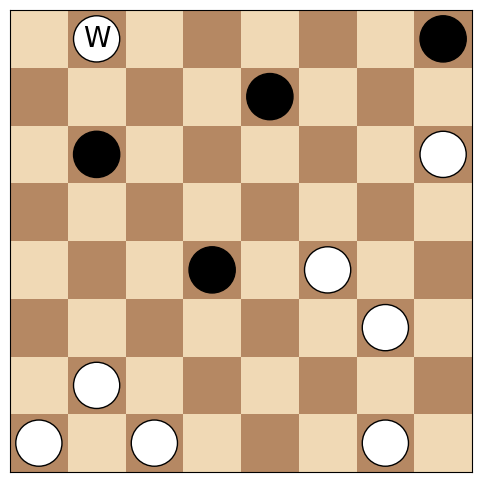

Movimiento de blanco desde (6, 1) a (5, 2) con prioridad 3

Turno 37 del jugador: negro


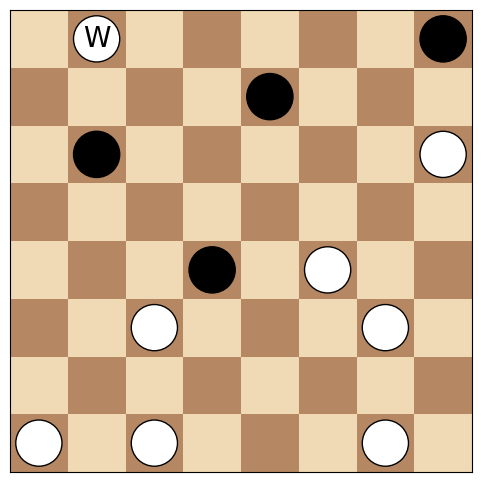

Movimiento de negro desde (4, 3) a (6, 1) con prioridad 2

Turno 38 del jugador: blanco


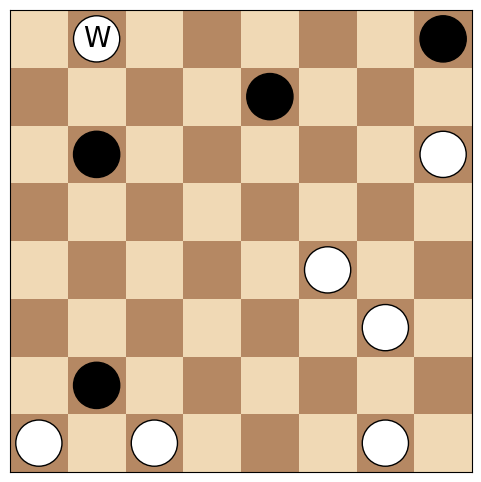

Movimiento de blanco desde (7, 2) a (5, 0) con prioridad 2

Turno 39 del jugador: negro


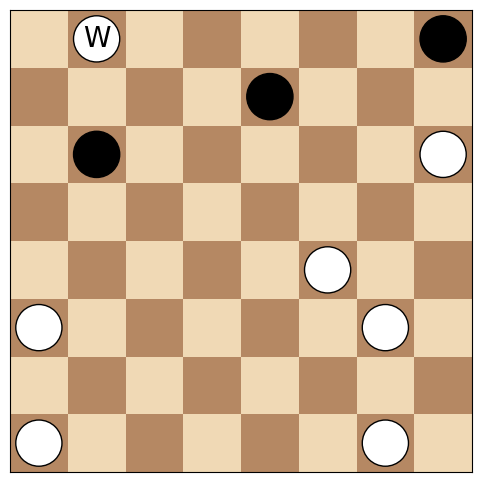

Movimiento de negro desde (2, 1) a (3, 2) con prioridad 3

Turno 40 del jugador: blanco


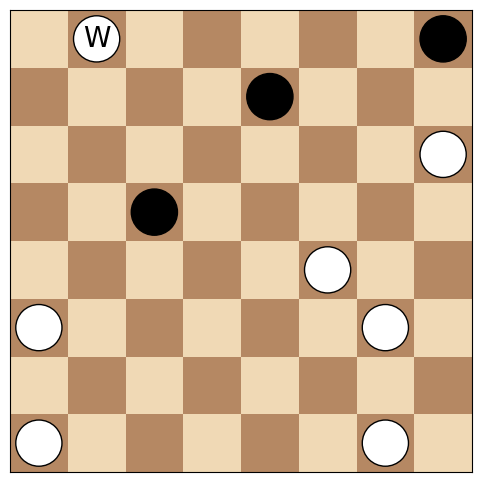

Movimiento de blanco desde (5, 0) a (4, 1) con prioridad 4

Turno 41 del jugador: negro


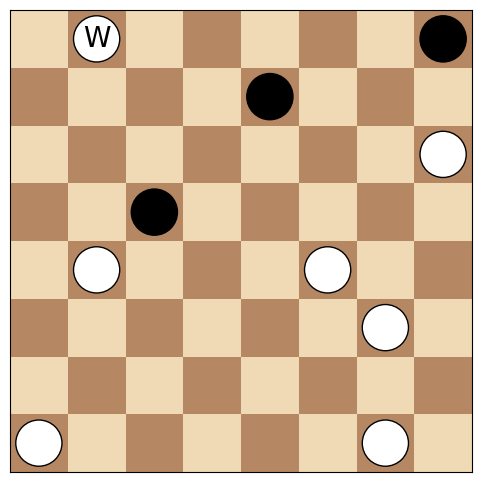

Movimiento de negro desde (3, 2) a (5, 0) con prioridad 2

Turno 42 del jugador: blanco


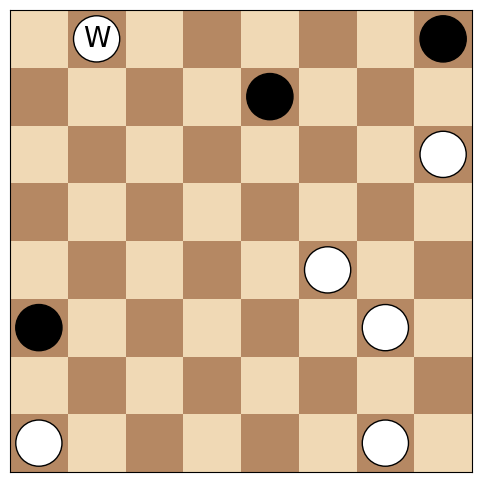

Movimiento de blanco desde (2, 7) a (1, 6) con prioridad 3

Turno 43 del jugador: negro


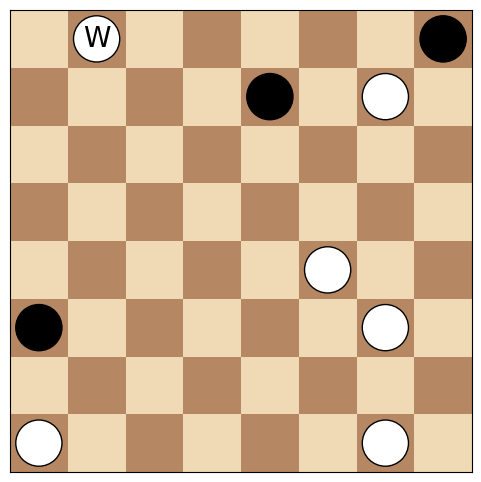

Movimiento de negro desde (0, 7) a (2, 5) con prioridad 2

Turno 44 del jugador: blanco


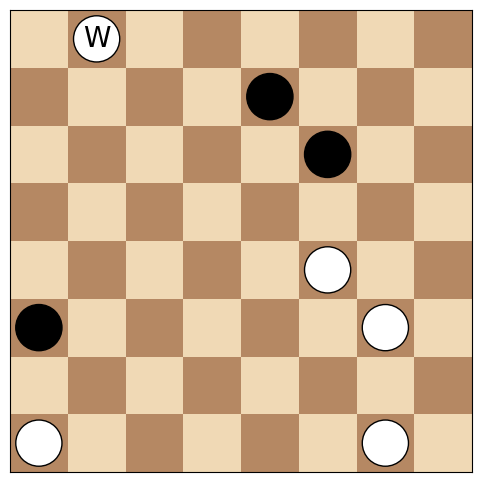

Movimiento de blanco desde (4, 5) a (3, 4) con prioridad 3

Turno 45 del jugador: negro


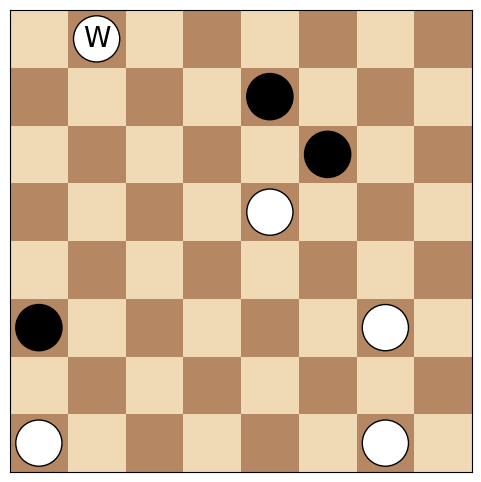

Movimiento de negro desde (2, 5) a (4, 3) con prioridad 2

Turno 46 del jugador: blanco


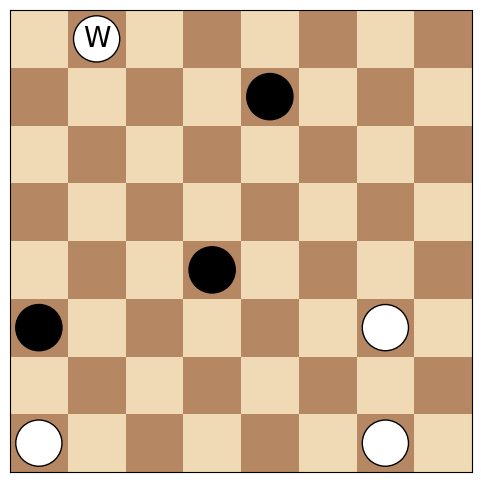

Movimiento de blanco desde (0, 1) a (1, 2) con prioridad 3

Turno 47 del jugador: negro


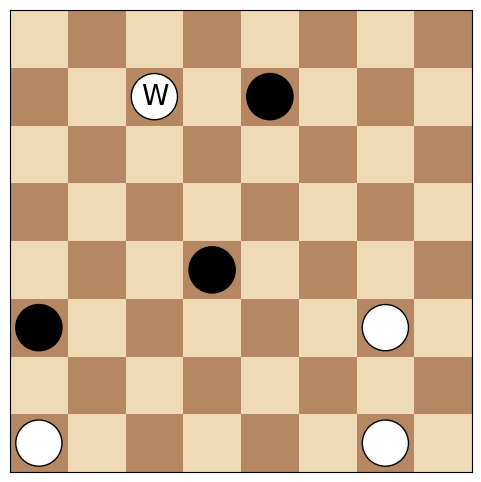

Movimiento de negro desde (5, 0) a (6, 1) con prioridad 4

Turno 48 del jugador: blanco


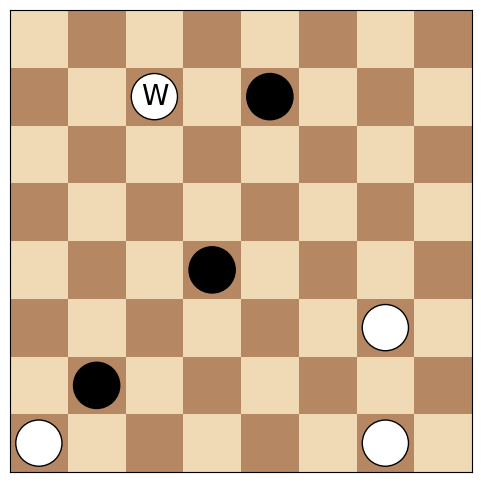

Movimiento de blanco desde (1, 2) a (2, 3) con prioridad 1

Turno 49 del jugador: negro


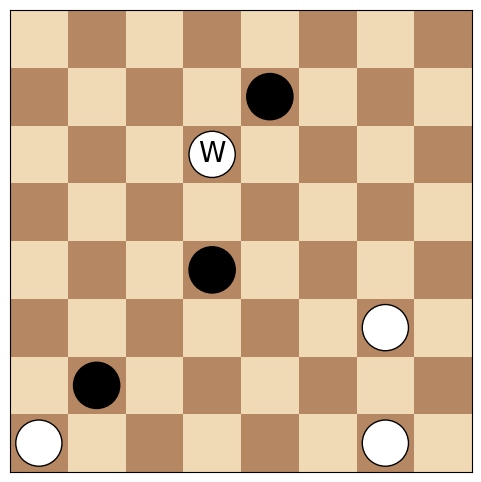

Movimiento de negro desde (6, 1) a (7, 2) con prioridad 1

Turno 50 del jugador: blanco


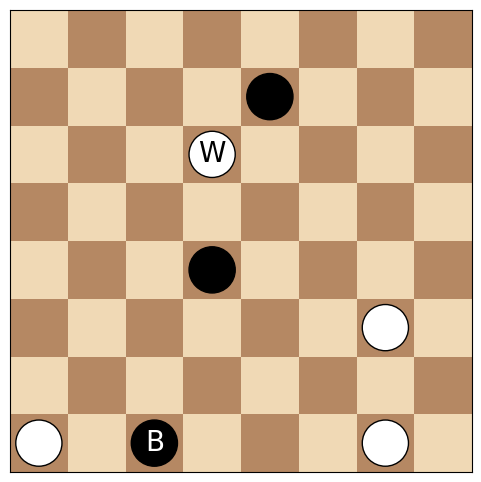

Movimiento de blanco desde (2, 3) a (0, 5) con prioridad 2

Turno 51 del jugador: negro


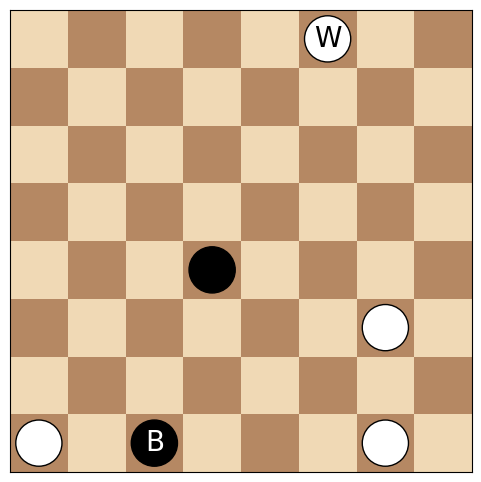

Movimiento de negro desde (7, 2) a (6, 3) con prioridad 3

Turno 52 del jugador: blanco


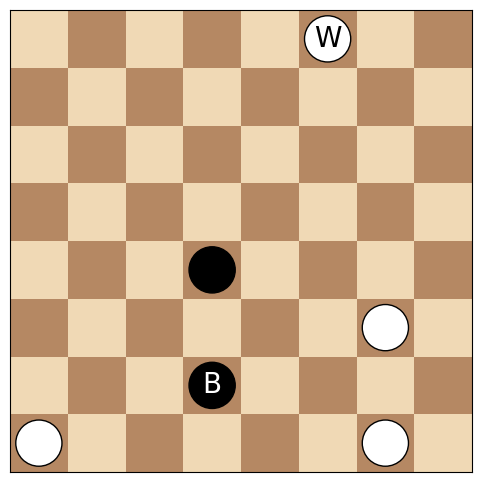

Movimiento de blanco desde (0, 5) a (1, 4) con prioridad 4

Turno 53 del jugador: negro


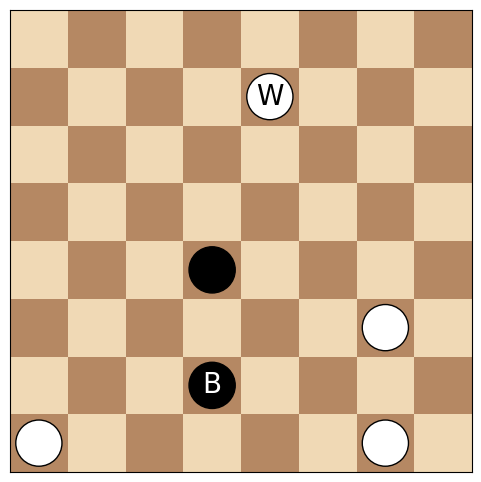

Movimiento de negro desde (6, 3) a (7, 4) con prioridad 1

Turno 54 del jugador: blanco


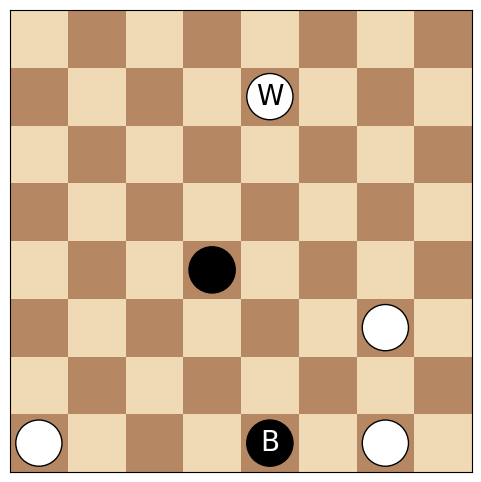

Movimiento de blanco desde (1, 4) a (2, 5) con prioridad 1

Turno 55 del jugador: negro


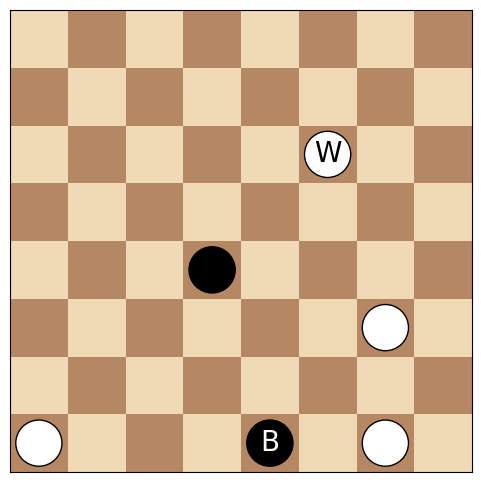

Movimiento de negro desde (7, 4) a (6, 5) con prioridad 4

Turno 56 del jugador: blanco


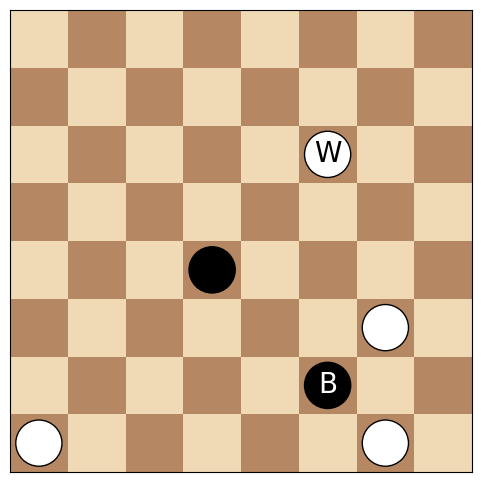

Movimiento de blanco desde (7, 6) a (5, 4) con prioridad 2

Turno 57 del jugador: negro


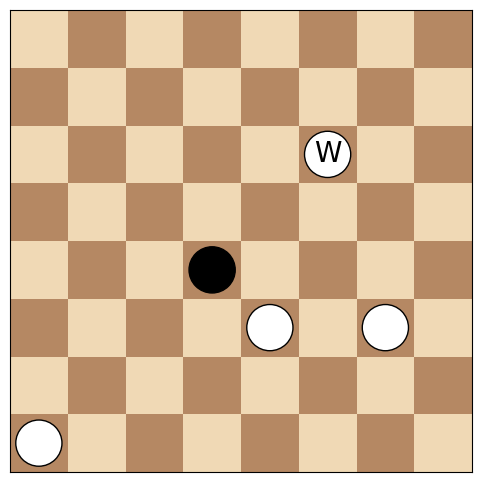

Movimiento de negro desde (4, 3) a (6, 5) con prioridad 2

Turno 58 del jugador: blanco


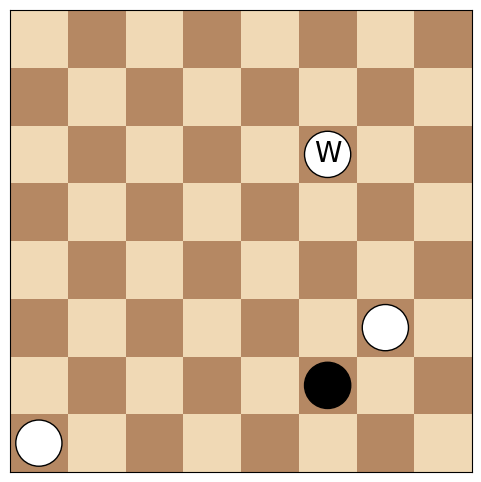

Movimiento de blanco desde (2, 5) a (1, 6) con prioridad 3

Turno 59 del jugador: negro


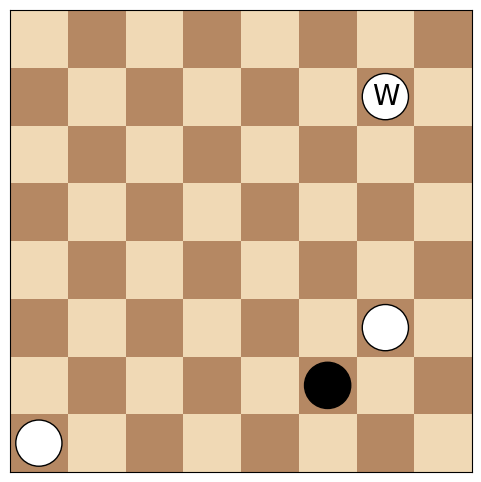

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 60 del jugador: blanco


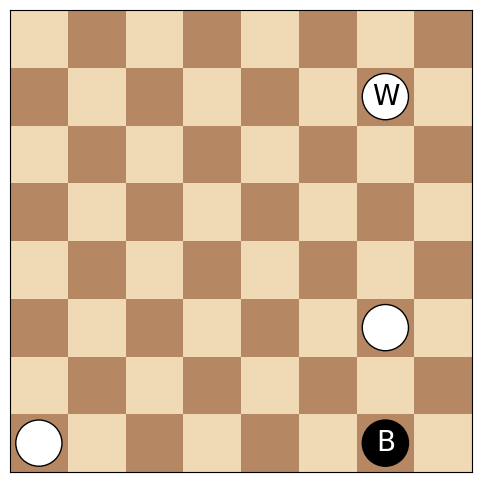

Movimiento de blanco desde (1, 6) a (2, 7) con prioridad 1

Turno 61 del jugador: negro


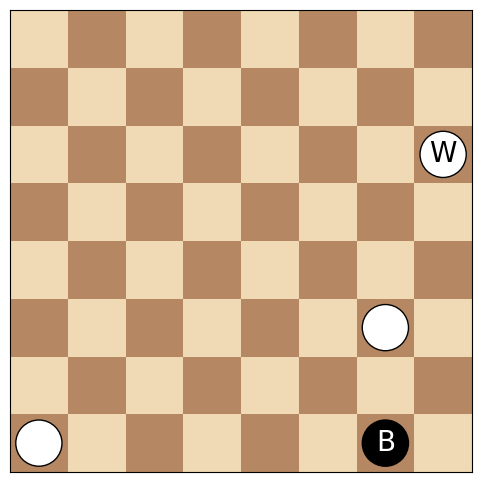

Movimiento de negro desde (7, 6) a (6, 5) con prioridad 4

Turno 62 del jugador: blanco


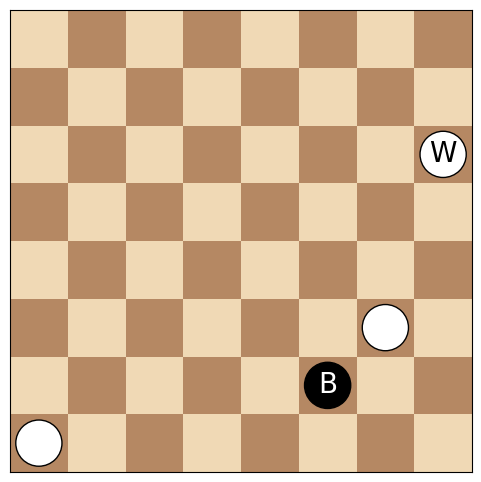

Movimiento de blanco desde (5, 6) a (4, 5) con prioridad 4

Turno 63 del jugador: negro


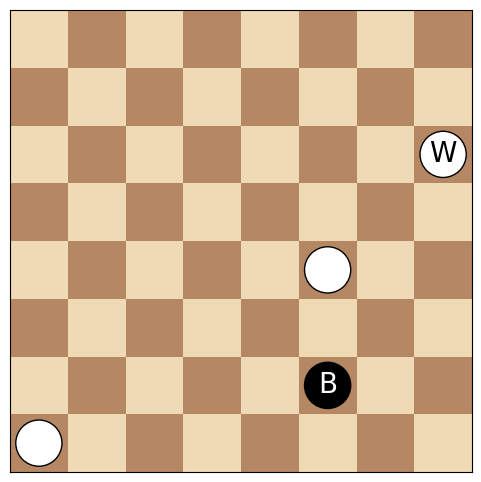

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 64 del jugador: blanco


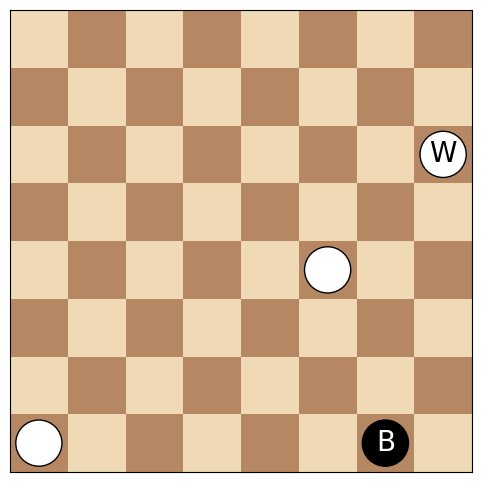

Movimiento de blanco desde (4, 5) a (3, 6) con prioridad 4

Turno 65 del jugador: negro


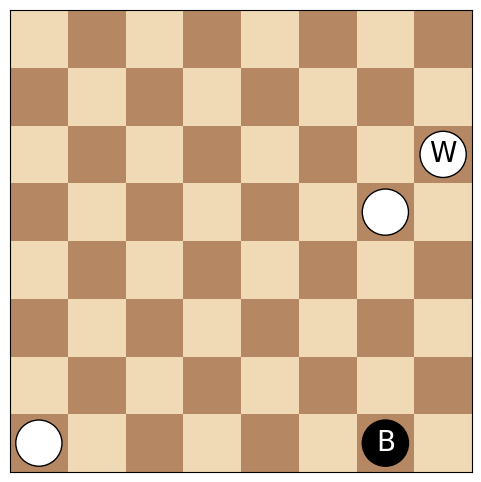

Movimiento de negro desde (7, 6) a (6, 7) con prioridad 7

Turno 66 del jugador: blanco


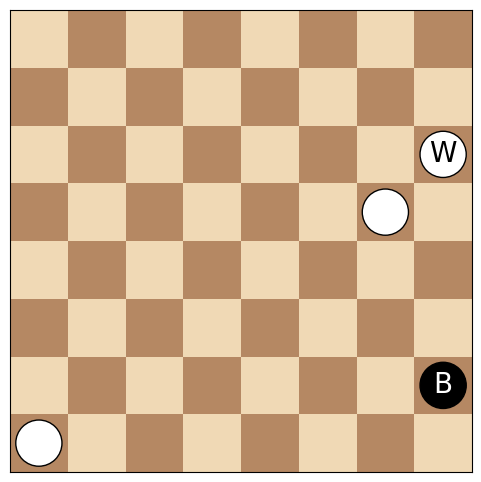

Movimiento de blanco desde (7, 0) a (6, 1) con prioridad 7

Turno 67 del jugador: negro


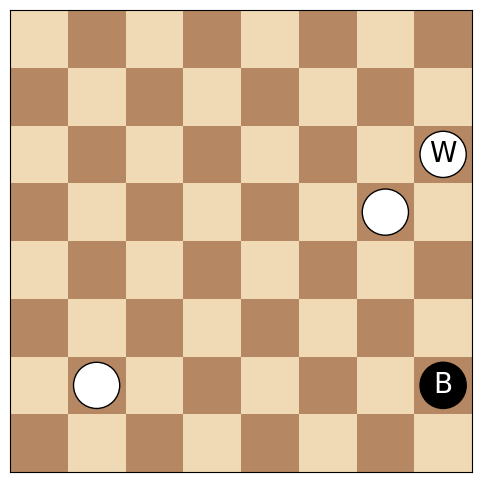

Movimiento de negro desde (6, 7) a (7, 6) con prioridad 1

Turno 68 del jugador: blanco


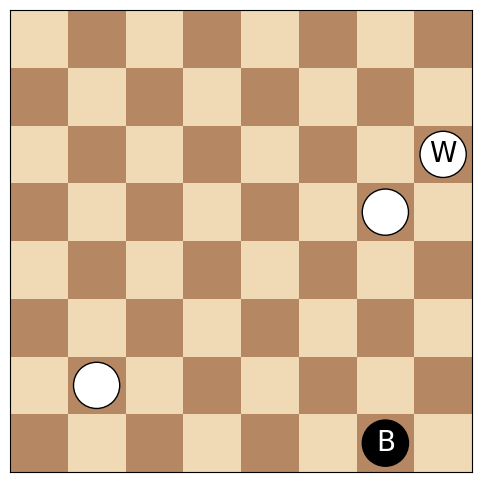

Movimiento de blanco desde (6, 1) a (5, 2) con prioridad 3

Turno 69 del jugador: negro


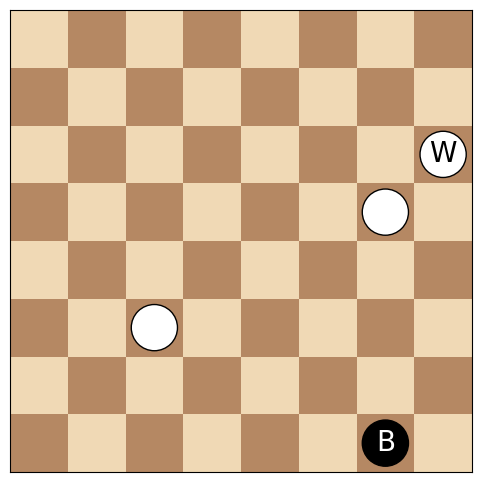

Movimiento de negro desde (7, 6) a (6, 5) con prioridad 5

Turno 70 del jugador: blanco


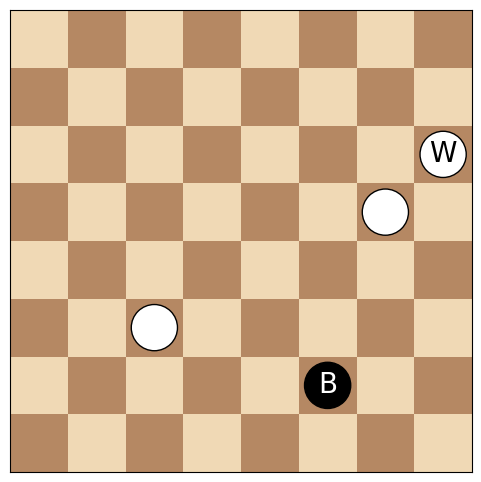

Movimiento de blanco desde (2, 7) a (1, 6) con prioridad 5

Turno 71 del jugador: negro


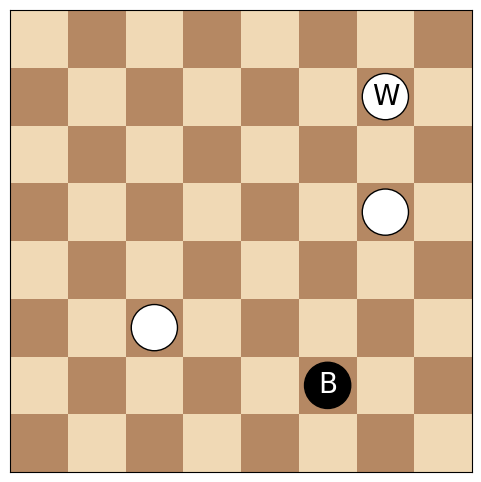

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 72 del jugador: blanco


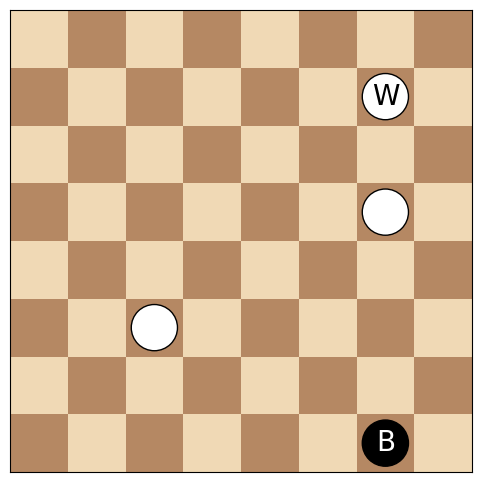

Movimiento de blanco desde (1, 6) a (2, 7) con prioridad 1

Turno 73 del jugador: negro


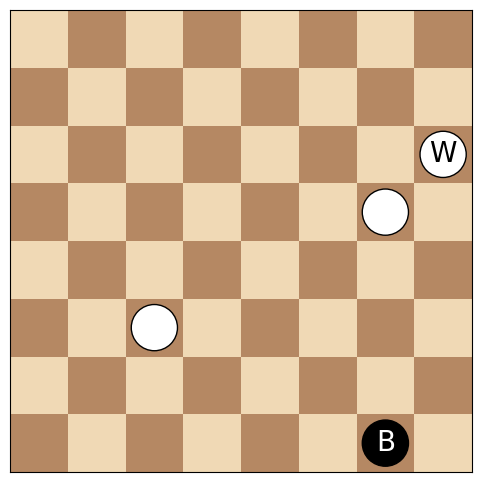

Movimiento de negro desde (7, 6) a (6, 5) con prioridad 5

Turno 74 del jugador: blanco


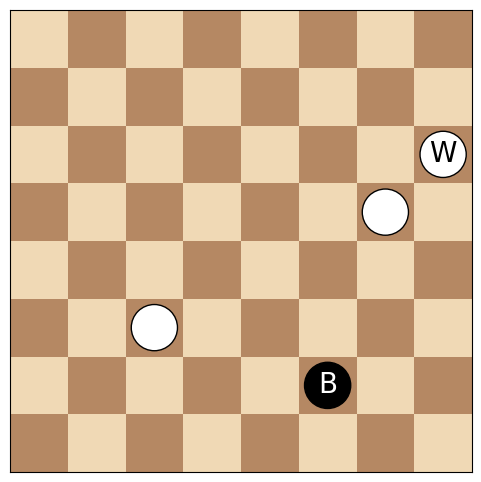

Movimiento de blanco desde (5, 2) a (4, 3) con prioridad 6

Turno 75 del jugador: negro


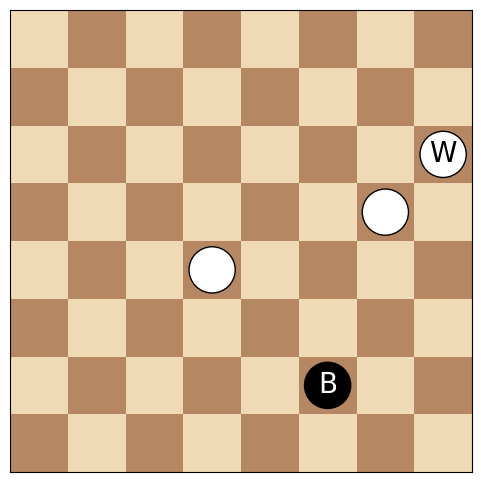

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 76 del jugador: blanco


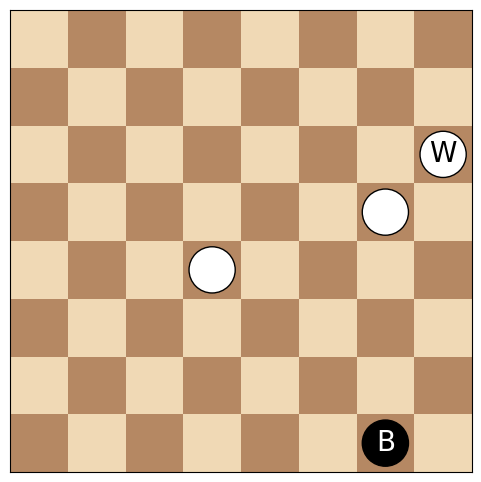

Movimiento de blanco desde (4, 3) a (3, 4) con prioridad 3

Turno 77 del jugador: negro


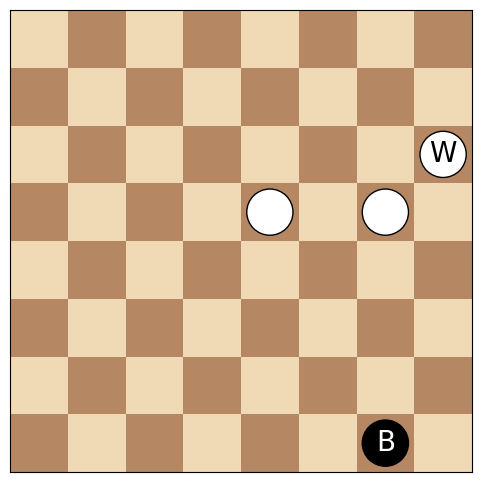

Movimiento de negro desde (7, 6) a (6, 5) con prioridad 7

Turno 78 del jugador: blanco


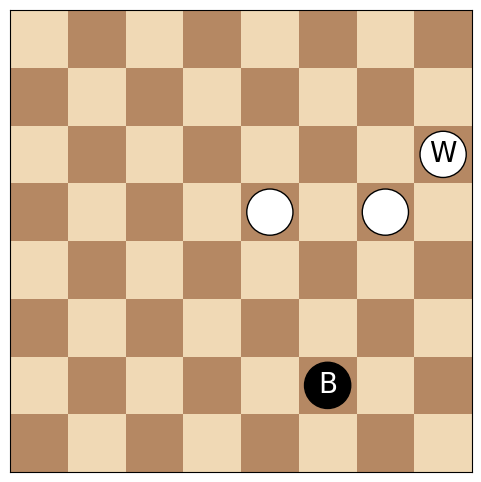

Movimiento de blanco desde (3, 6) a (2, 5) con prioridad 7

Turno 79 del jugador: negro


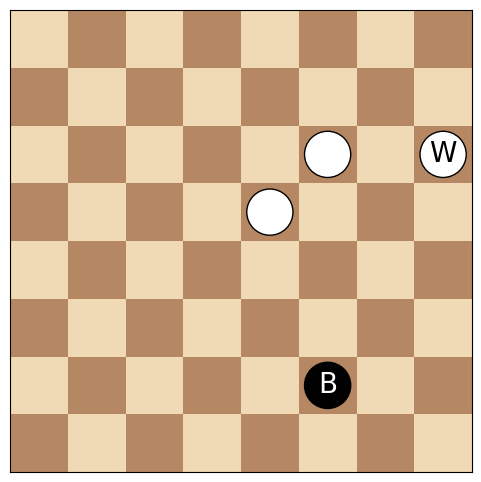

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 80 del jugador: blanco


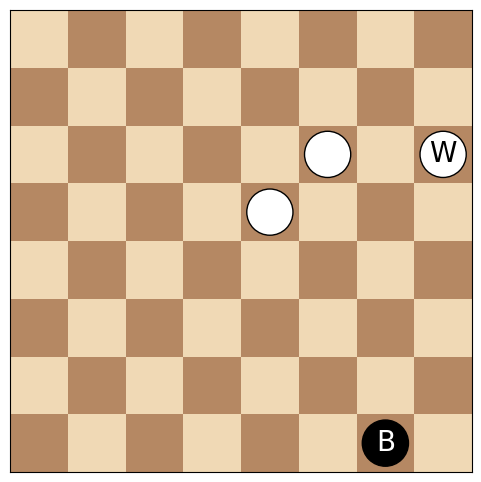

Movimiento de blanco desde (2, 7) a (3, 6) con prioridad 4

Turno 81 del jugador: negro


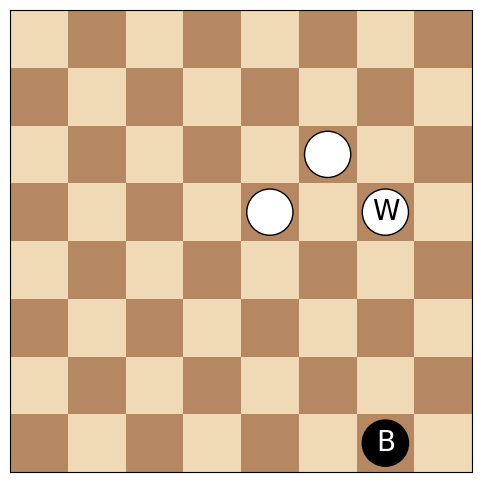

Movimiento de negro desde (7, 6) a (6, 5) con prioridad 5

Turno 82 del jugador: blanco


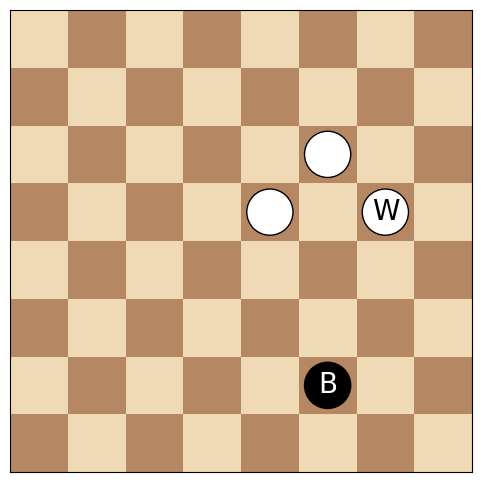

Movimiento de blanco desde (2, 5) a (1, 4) con prioridad 3

Turno 83 del jugador: negro


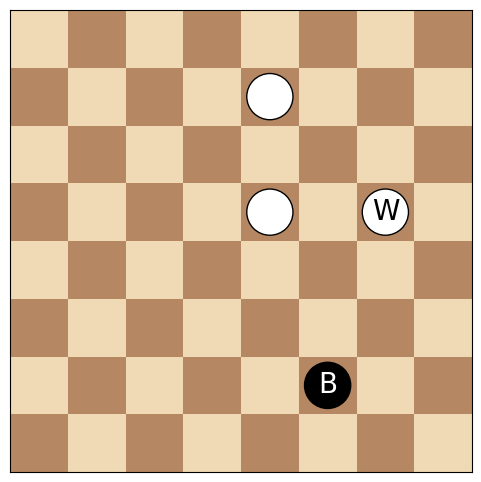

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 84 del jugador: blanco


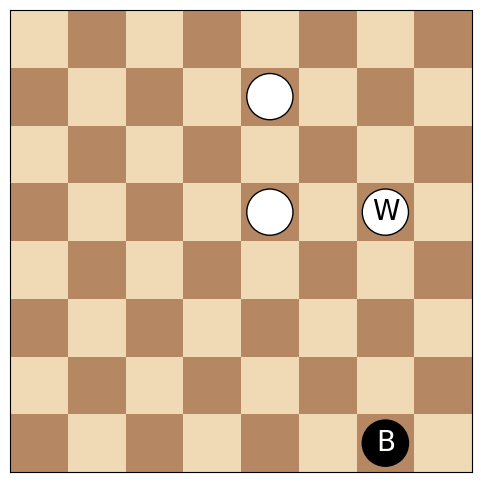

Movimiento de blanco desde (1, 4) a (0, 5) con prioridad 1

Turno 85 del jugador: negro


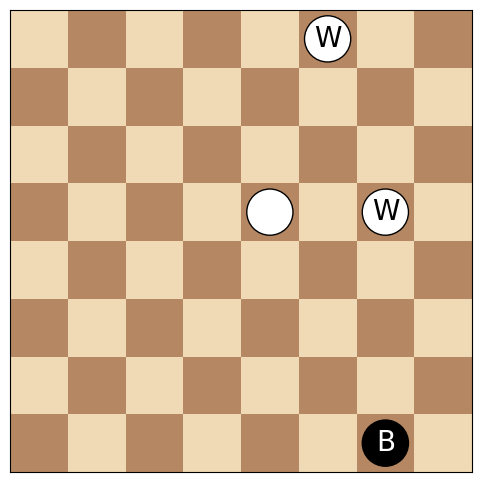

Movimiento de negro desde (7, 6) a (6, 5) con prioridad 6

Turno 86 del jugador: blanco


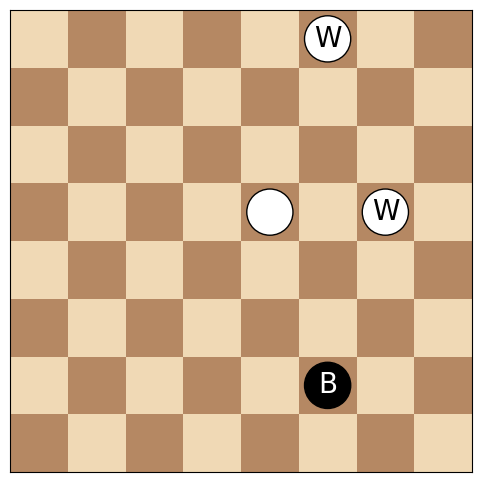

Movimiento de blanco desde (3, 6) a (4, 7) con prioridad 3

Turno 87 del jugador: negro


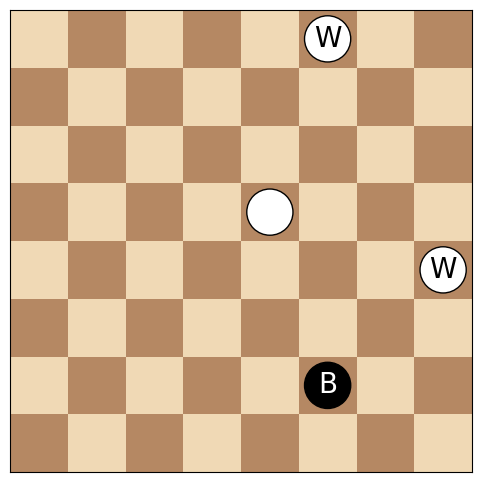

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 88 del jugador: blanco


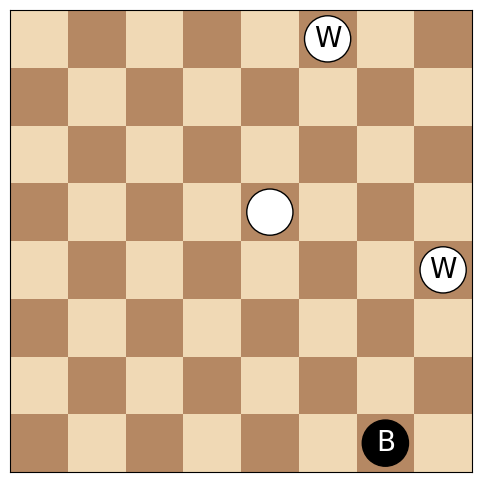

Movimiento de blanco desde (3, 4) a (2, 5) con prioridad 3

Turno 89 del jugador: negro


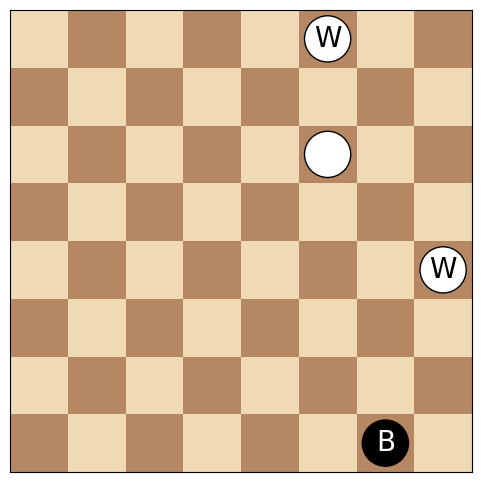

Movimiento de negro desde (7, 6) a (6, 5) con prioridad 4

Turno 90 del jugador: blanco


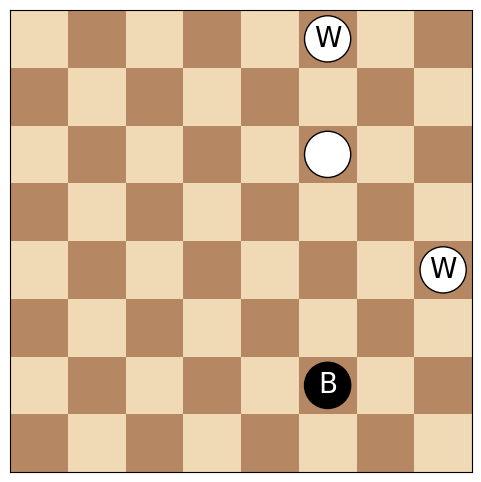

Movimiento de blanco desde (2, 5) a (1, 6) con prioridad 3

Turno 91 del jugador: negro


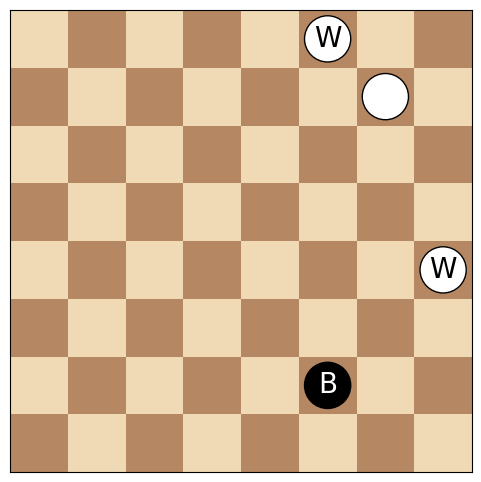

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 92 del jugador: blanco


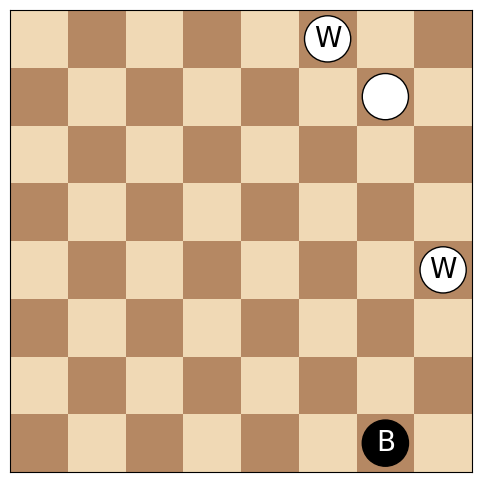

Movimiento de blanco desde (1, 6) a (0, 7) con prioridad 1

Turno 93 del jugador: negro


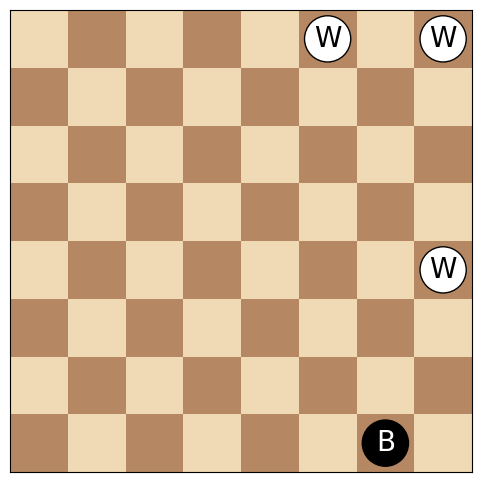

Movimiento de negro desde (7, 6) a (6, 5) con prioridad 4

Turno 94 del jugador: blanco


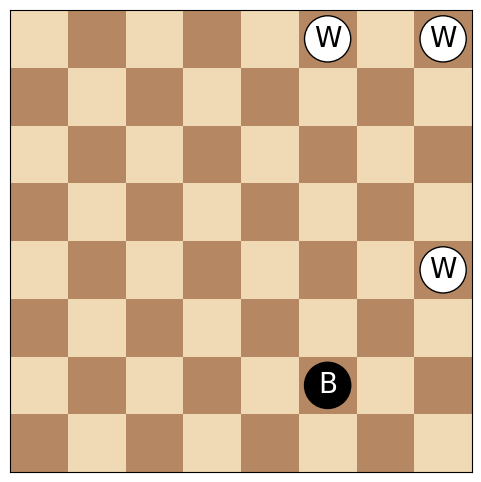

Movimiento de blanco desde (4, 7) a (3, 6) con prioridad 3

Turno 95 del jugador: negro


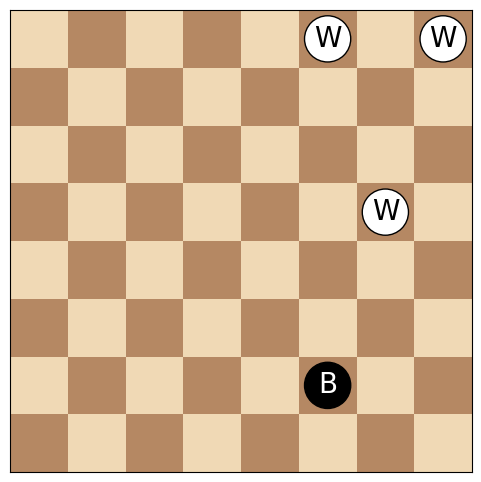

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 96 del jugador: blanco


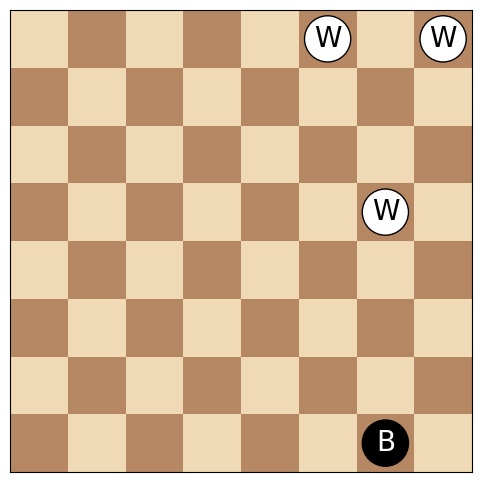

Movimiento de blanco desde (3, 6) a (2, 7) con prioridad 3

Turno 97 del jugador: negro


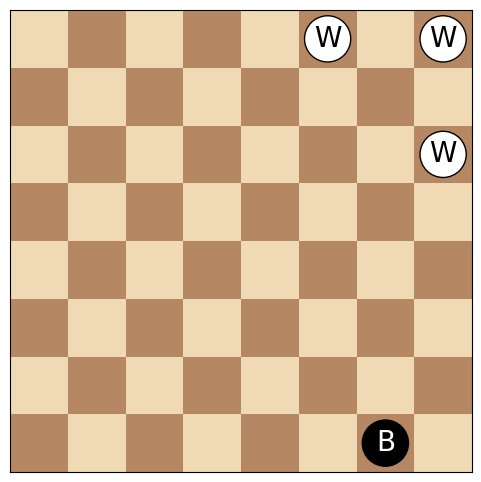

Movimiento de negro desde (7, 6) a (6, 5) con prioridad 8

Turno 98 del jugador: blanco


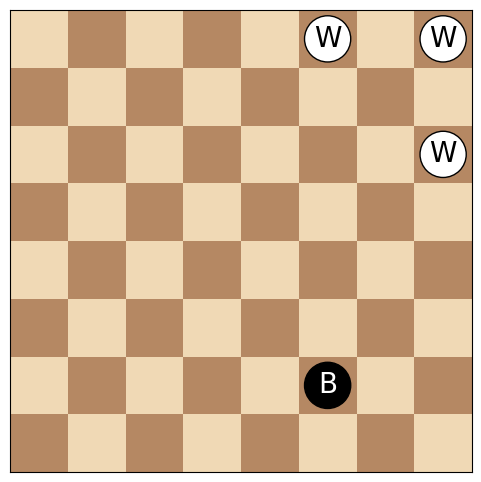

Movimiento de blanco desde (2, 7) a (3, 6) con prioridad 3

Turno 99 del jugador: negro


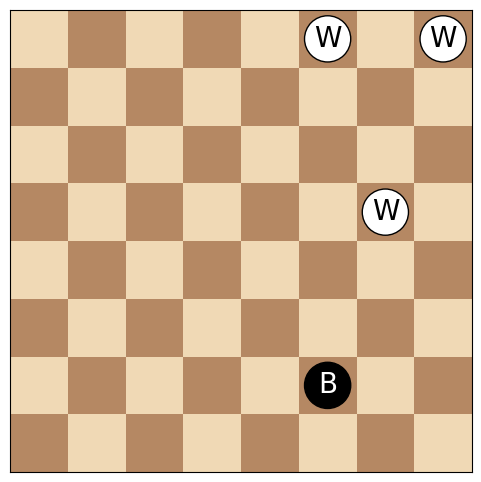

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 100 del jugador: blanco


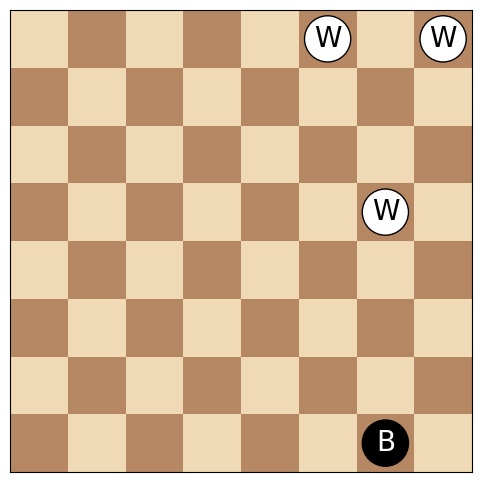

Movimiento de blanco desde (3, 6) a (4, 7) con prioridad 5

Turno 101 del jugador: negro


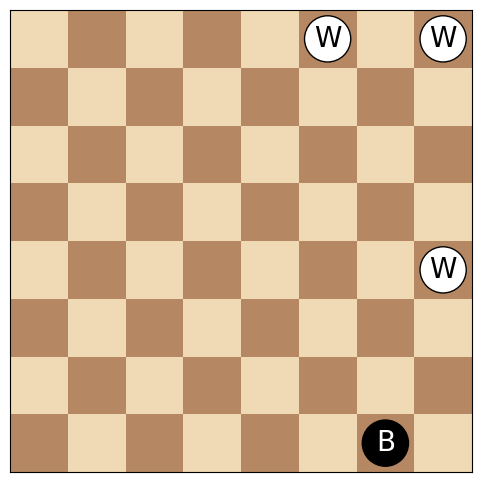

Movimiento de negro desde (7, 6) a (6, 5) con prioridad 4

Turno 102 del jugador: blanco


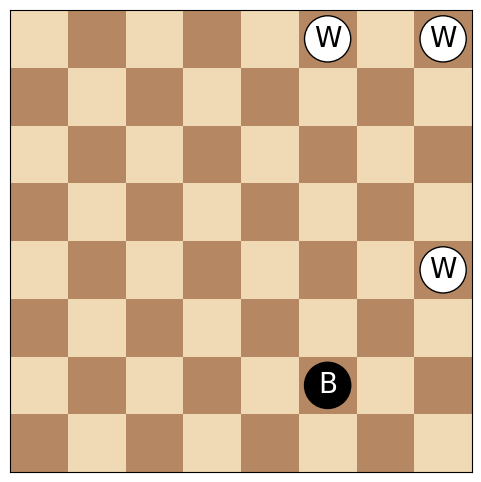

Movimiento de blanco desde (4, 7) a (3, 6) con prioridad 3

Turno 103 del jugador: negro


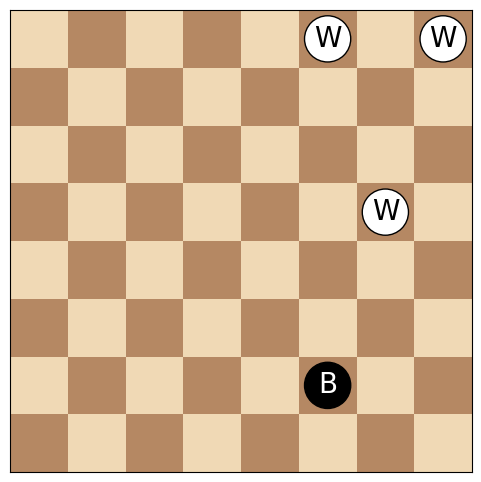

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 104 del jugador: blanco


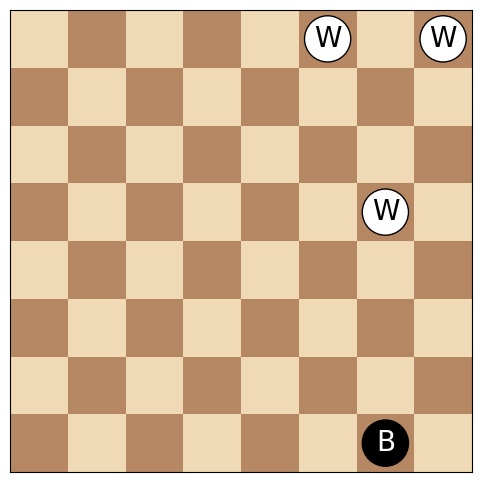

Movimiento de blanco desde (0, 5) a (1, 6) con prioridad 3

Turno 105 del jugador: negro


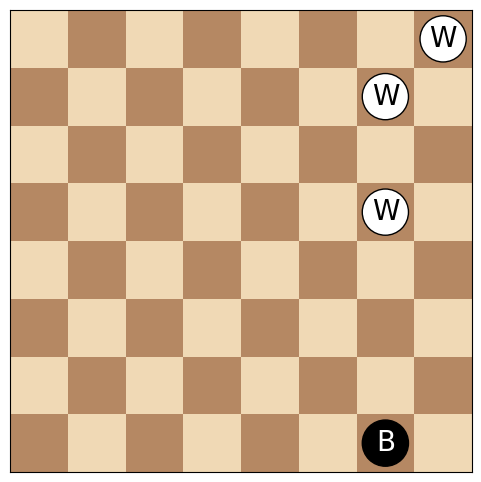

Movimiento de negro desde (7, 6) a (6, 7) con prioridad 6

Turno 106 del jugador: blanco


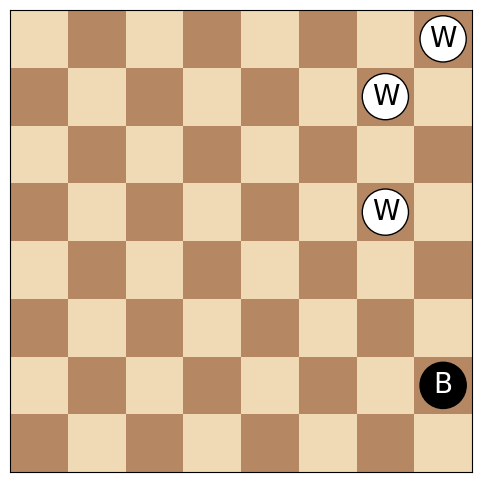

Movimiento de blanco desde (1, 6) a (2, 7) con prioridad 1

Turno 107 del jugador: negro


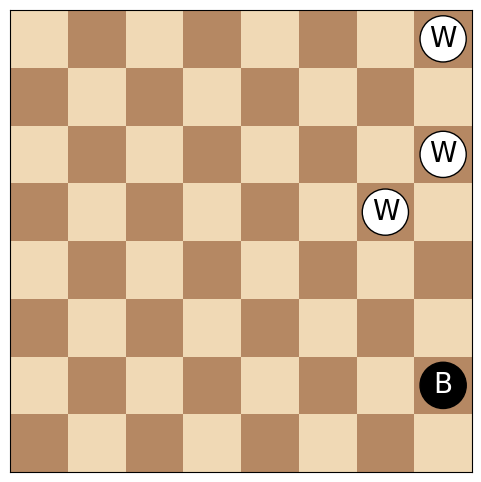

Movimiento de negro desde (6, 7) a (7, 6) con prioridad 1

Turno 108 del jugador: blanco


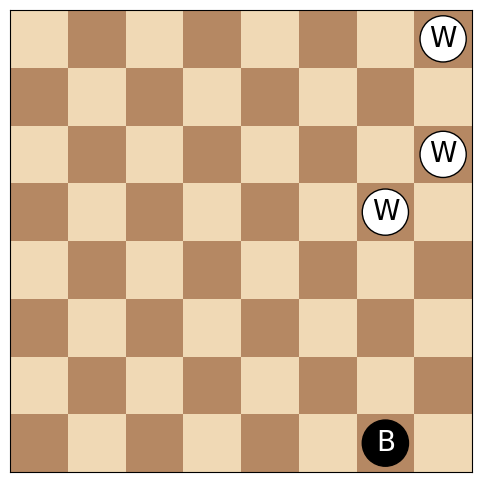

Movimiento de blanco desde (3, 6) a (4, 7) con prioridad 4

Turno 109 del jugador: negro


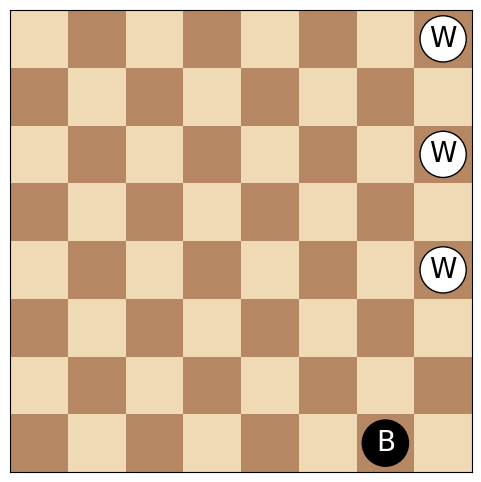

Movimiento de negro desde (7, 6) a (6, 7) con prioridad 5

Turno 110 del jugador: blanco


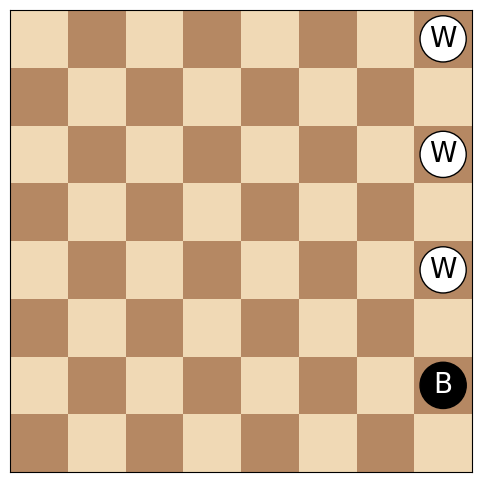

Movimiento de blanco desde (4, 7) a (5, 6) con prioridad 4

Turno 111 del jugador: negro


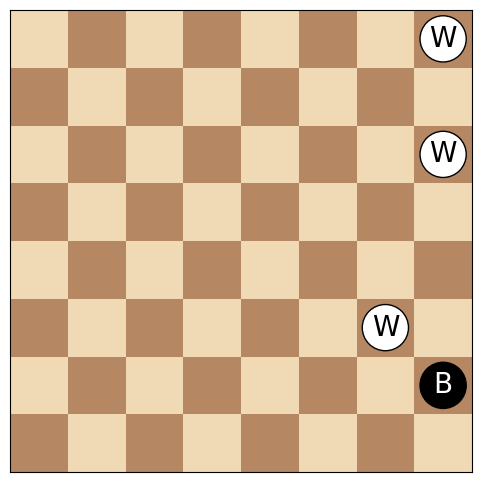

Movimiento de negro desde (6, 7) a (7, 6) con prioridad 1

Turno 112 del jugador: blanco


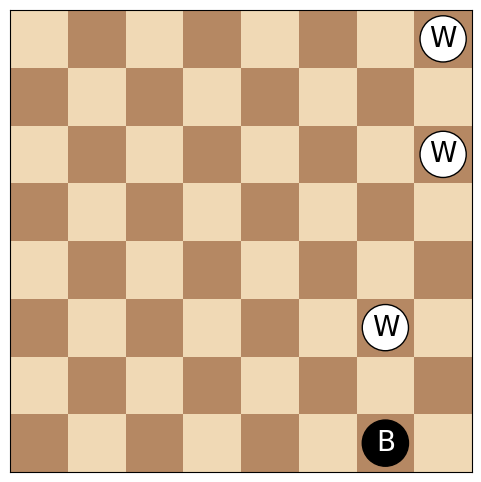

Movimiento de blanco desde (5, 6) a (4, 7) con prioridad 4

Turno 113 del jugador: negro


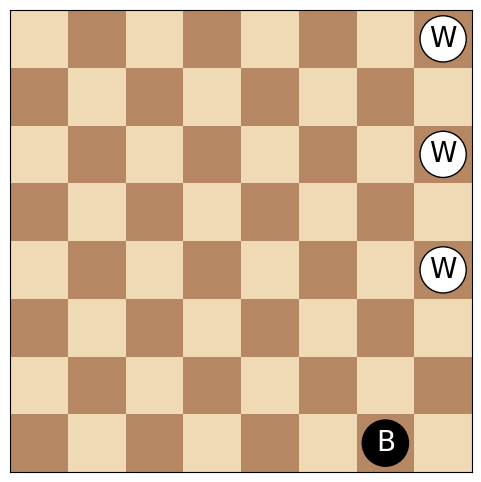

Movimiento de negro desde (7, 6) a (6, 7) con prioridad 4

Turno 114 del jugador: blanco


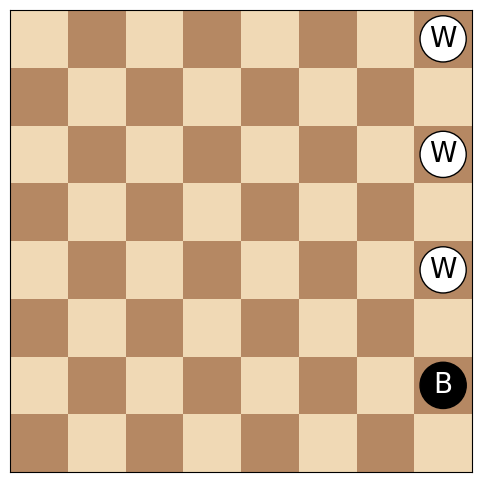

Movimiento de blanco desde (2, 7) a (1, 6) con prioridad 3

Turno 115 del jugador: negro


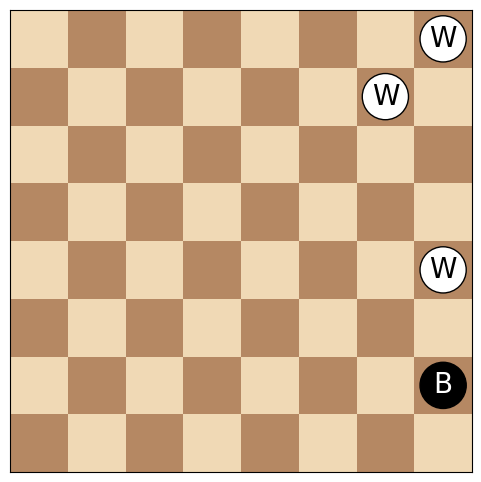

Movimiento de negro desde (6, 7) a (7, 6) con prioridad 1

Turno 116 del jugador: blanco


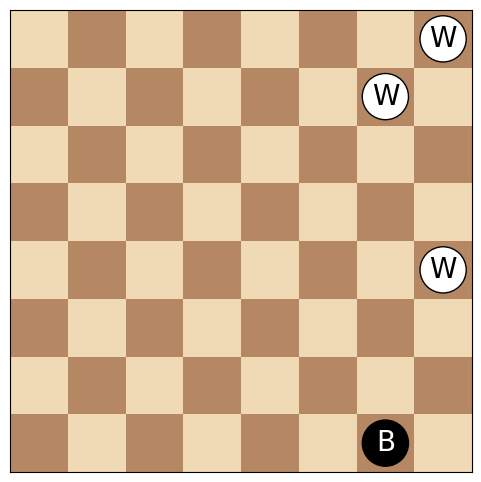

Movimiento de blanco desde (1, 6) a (2, 7) con prioridad 1

Turno 117 del jugador: negro


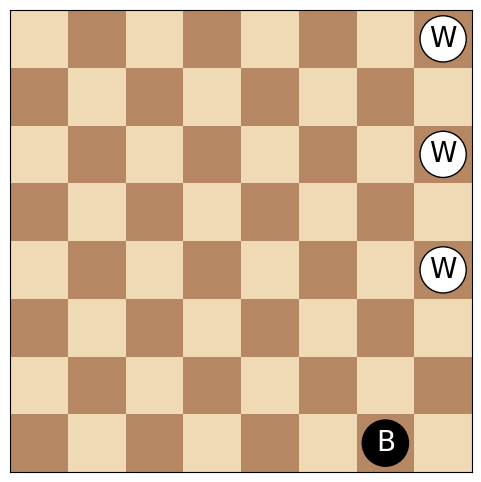

Movimiento de negro desde (7, 6) a (6, 7) con prioridad 3

Turno 118 del jugador: blanco


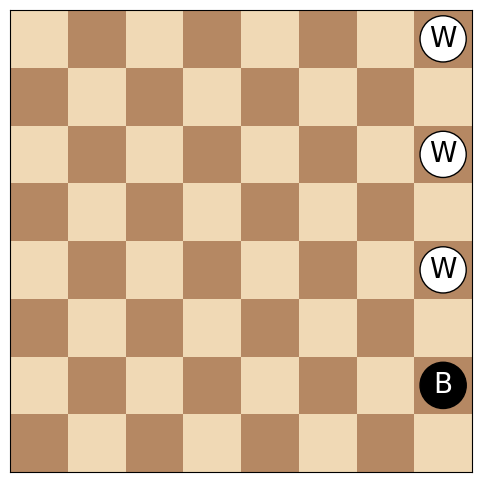

Movimiento de blanco desde (4, 7) a (3, 6) con prioridad 6

Turno 119 del jugador: negro


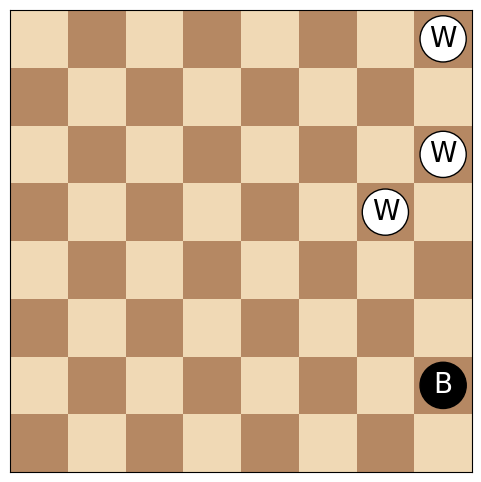

Movimiento de negro desde (6, 7) a (7, 6) con prioridad 1

Turno 120 del jugador: blanco


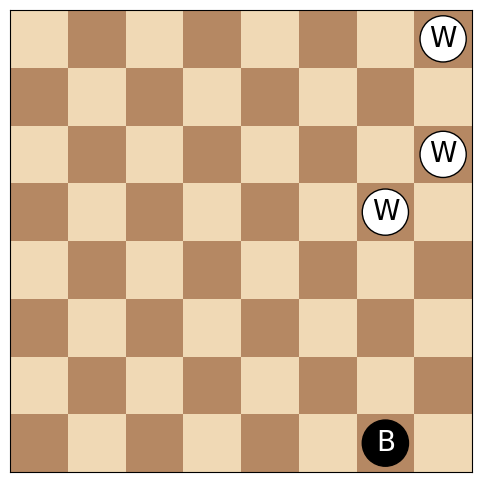

Movimiento de blanco desde (2, 7) a (1, 6) con prioridad 3

Turno 121 del jugador: negro


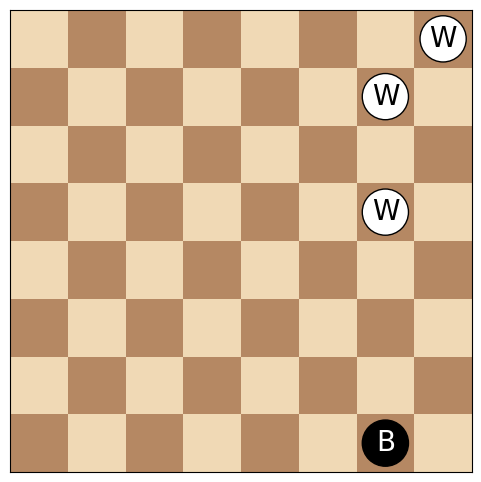

Movimiento de negro desde (7, 6) a (6, 7) con prioridad 4

Turno 122 del jugador: blanco


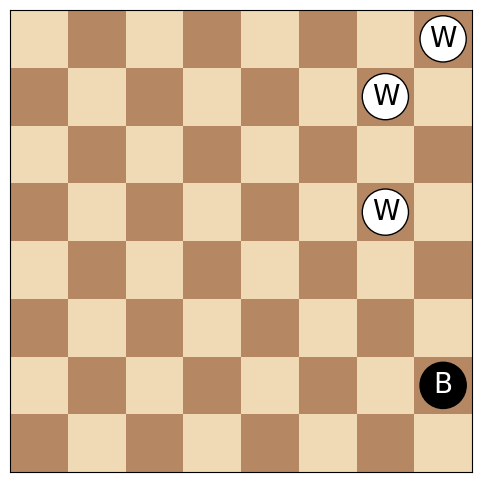

Movimiento de blanco desde (1, 6) a (2, 7) con prioridad 1

Turno 123 del jugador: negro


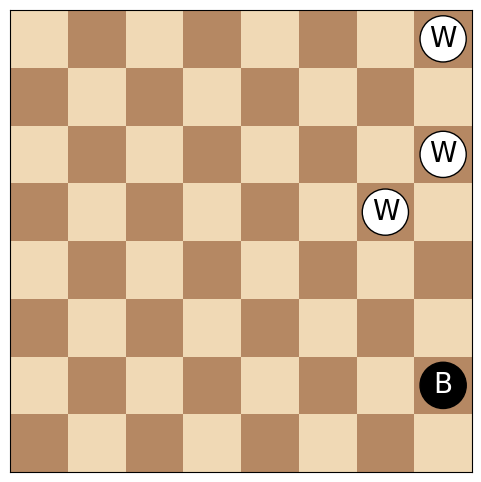

Movimiento de negro desde (6, 7) a (7, 6) con prioridad 1

Turno 124 del jugador: blanco


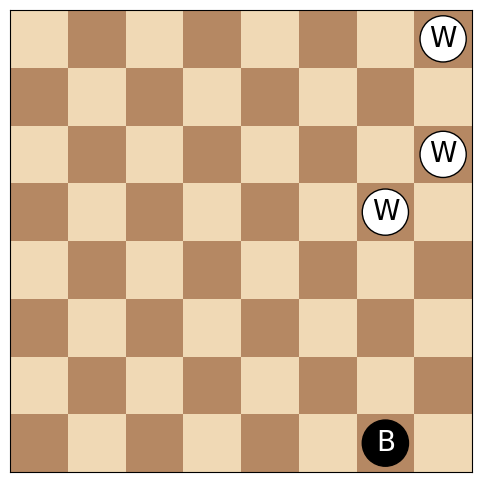

Movimiento de blanco desde (3, 6) a (4, 5) con prioridad 3

Turno 125 del jugador: negro


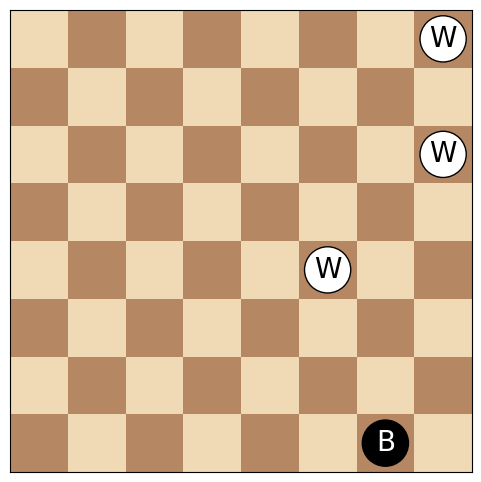

Movimiento de negro desde (7, 6) a (6, 5) con prioridad 3

Turno 126 del jugador: blanco


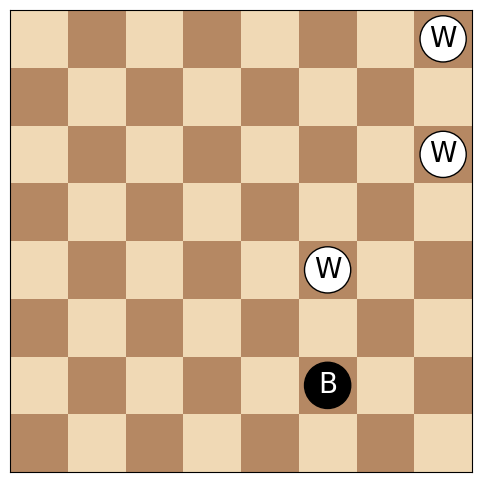

Movimiento de blanco desde (4, 5) a (5, 4) con prioridad 3

Turno 127 del jugador: negro


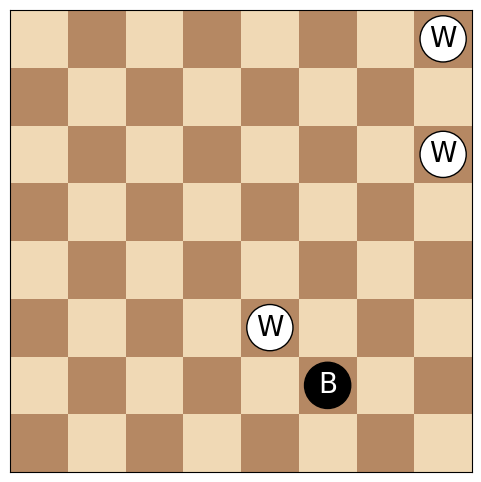

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 128 del jugador: blanco


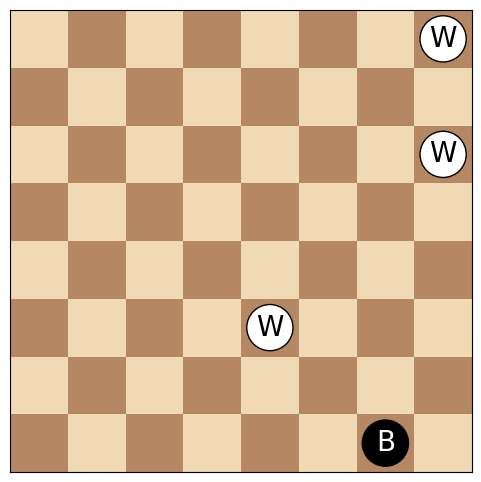

Movimiento de blanco desde (5, 4) a (6, 5) con prioridad 3

Turno 129 del jugador: negro


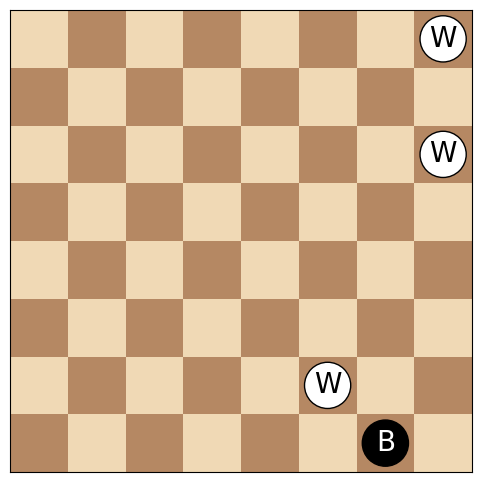

Movimiento de negro desde (7, 6) a (5, 4) con prioridad 2

Turno 130 del jugador: blanco


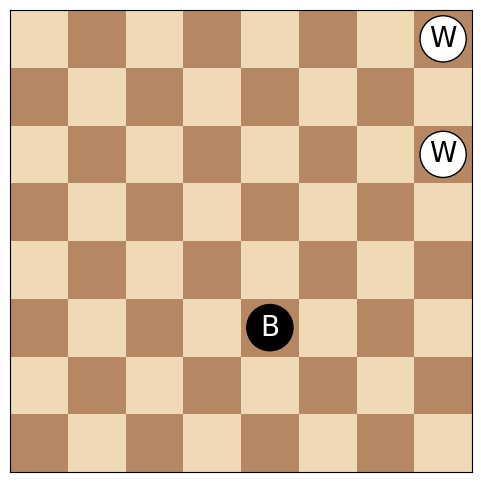

Movimiento de blanco desde (0, 7) a (1, 6) con prioridad 5

Turno 131 del jugador: negro


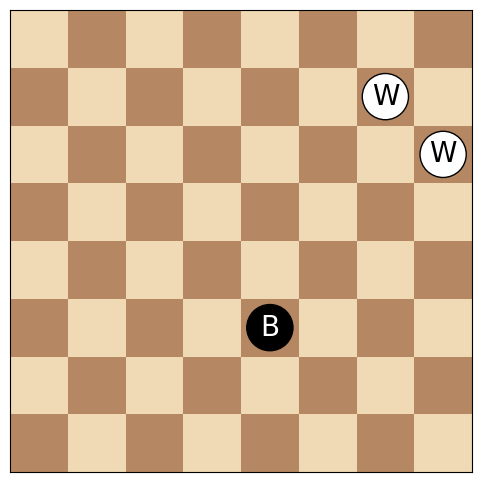

Movimiento de negro desde (5, 4) a (6, 5) con prioridad 3

Turno 132 del jugador: blanco


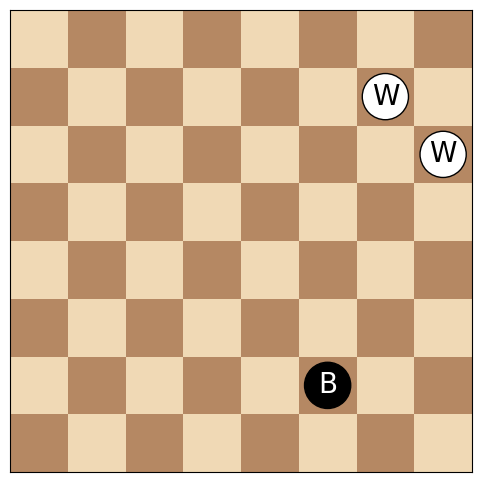

Movimiento de blanco desde (1, 6) a (2, 5) con prioridad 1

Turno 133 del jugador: negro


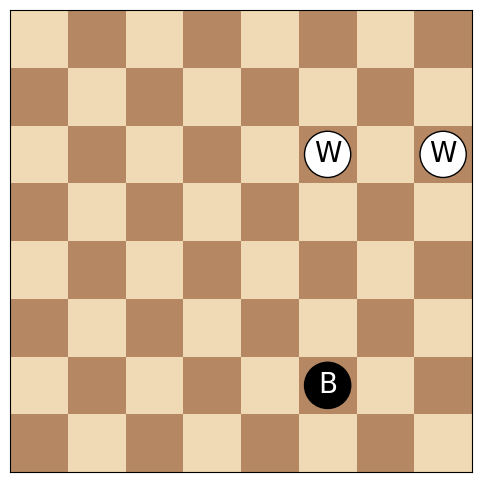

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 134 del jugador: blanco


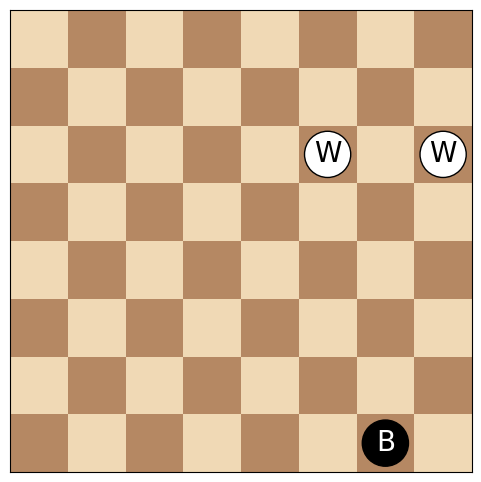

Movimiento de blanco desde (2, 5) a (1, 4) con prioridad 3

Turno 135 del jugador: negro


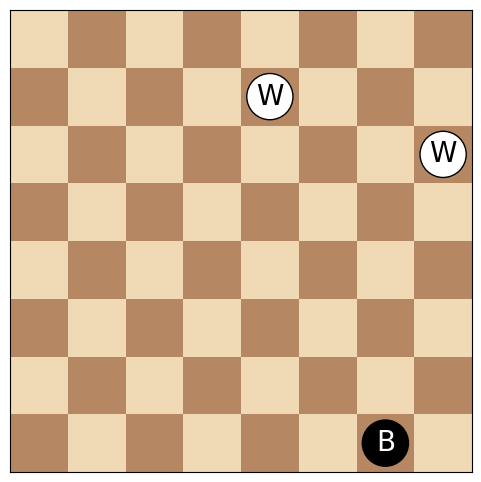

Movimiento de negro desde (7, 6) a (6, 5) con prioridad 5

Turno 136 del jugador: blanco


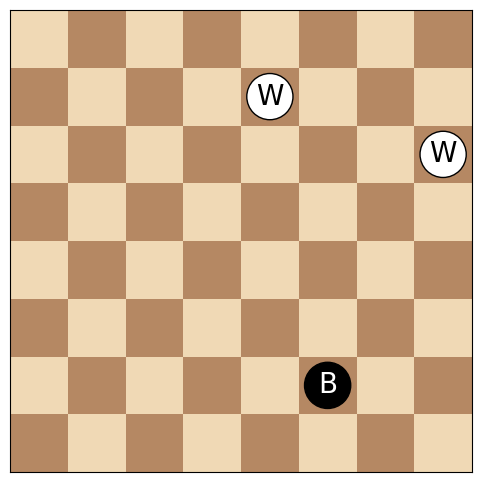

Movimiento de blanco desde (1, 4) a (2, 5) con prioridad 1

Turno 137 del jugador: negro


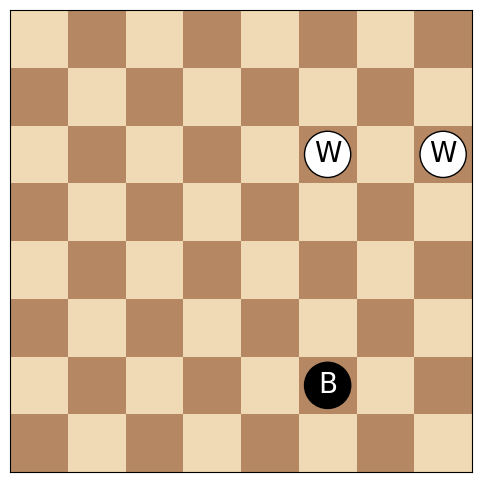

Movimiento de negro desde (6, 5) a (7, 6) con prioridad 1

Turno 138 del jugador: blanco


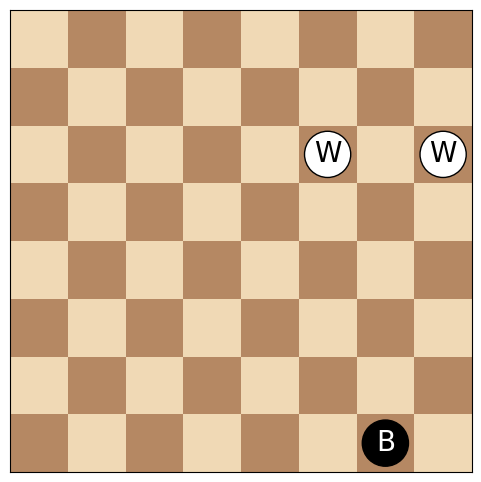

Movimiento de blanco desde (2, 5) a (1, 4) con prioridad 3

Turno 139 del jugador: negro


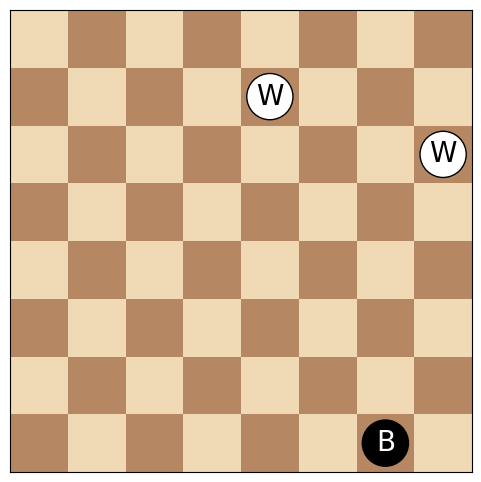

Movimiento de negro desde (7, 6) a (6, 7) con prioridad 4

Turno 140 del jugador: blanco


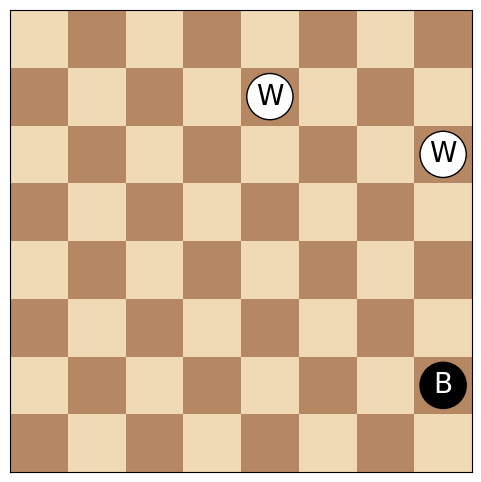

Movimiento de blanco desde (1, 4) a (2, 5) con prioridad 1

Turno 141 del jugador: negro


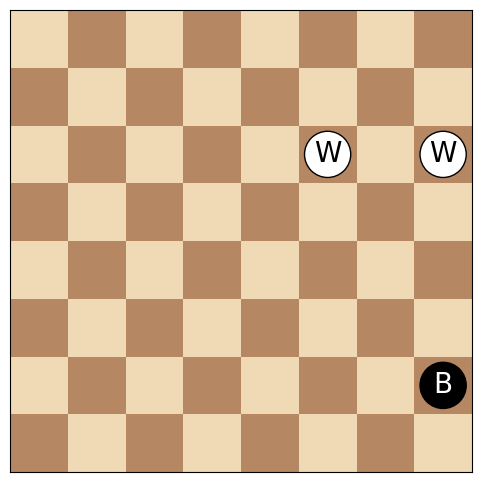

Movimiento de negro desde (6, 7) a (7, 6) con prioridad 1

Turno 142 del jugador: blanco


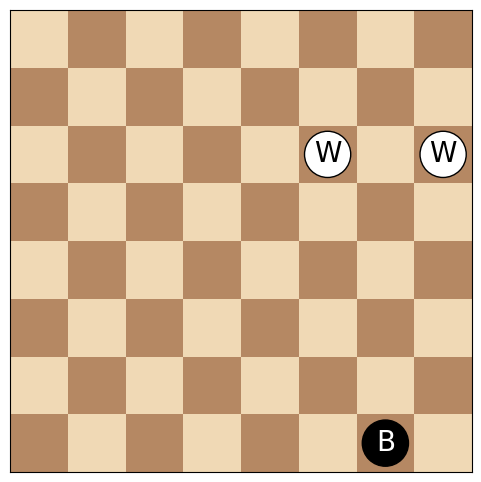

Movimiento de blanco desde (2, 7) a (3, 6) con prioridad 4

Turno 143 del jugador: negro


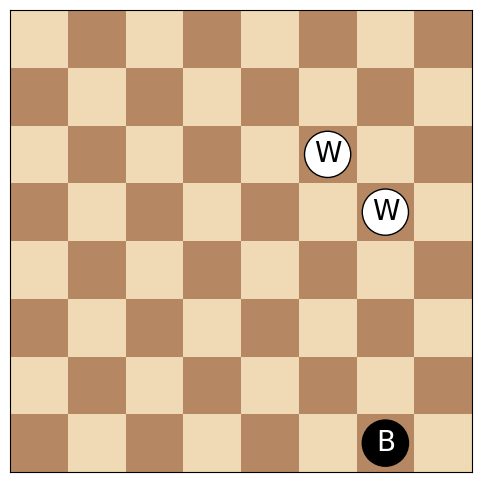

Movimiento de negro desde (7, 6) a (6, 7) con prioridad 6

Turno 144 del jugador: blanco


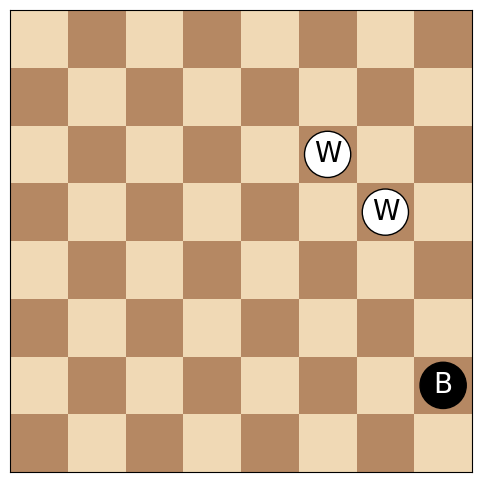

Movimiento de blanco desde (3, 6) a (2, 7) con prioridad 3

Turno 145 del jugador: negro


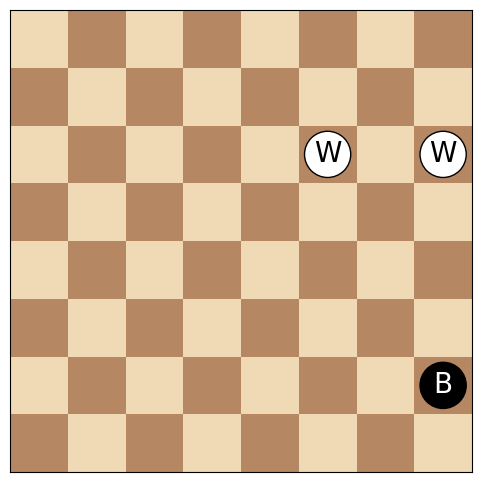

Movimiento de negro desde (6, 7) a (7, 6) con prioridad 1

Turno 146 del jugador: blanco


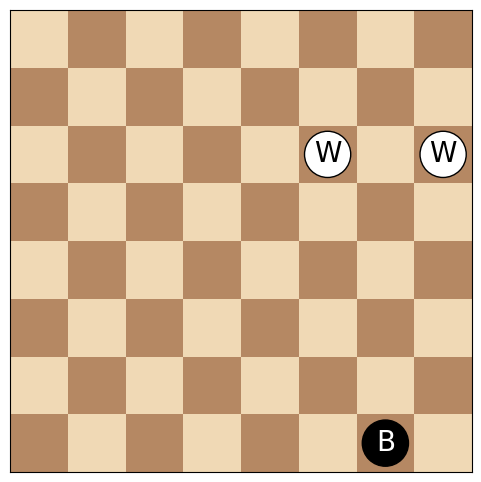

Movimiento de blanco desde (2, 5) a (3, 6) con prioridad 3

Turno 147 del jugador: negro


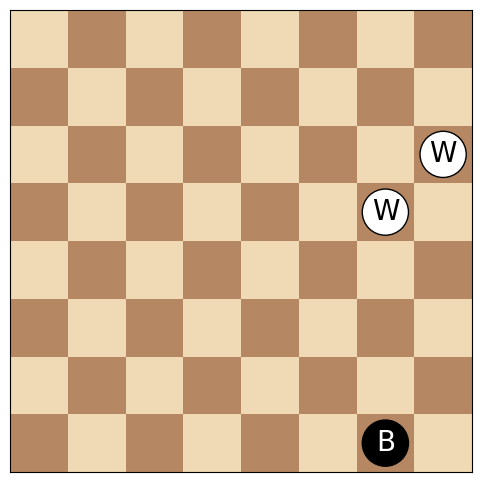

Movimiento de negro desde (7, 6) a (6, 7) con prioridad 8

Turno 148 del jugador: blanco


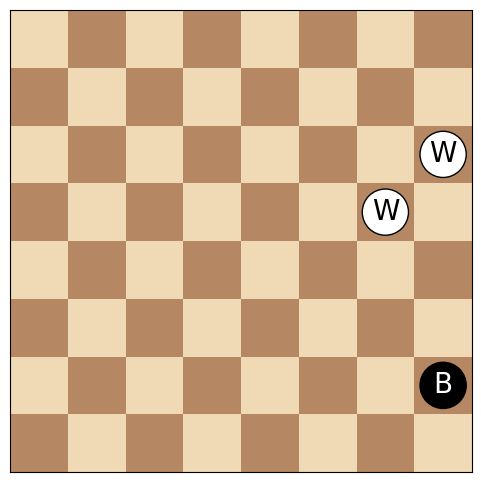

Movimiento de blanco desde (2, 7) a (1, 6) con prioridad 7

Turno 149 del jugador: negro


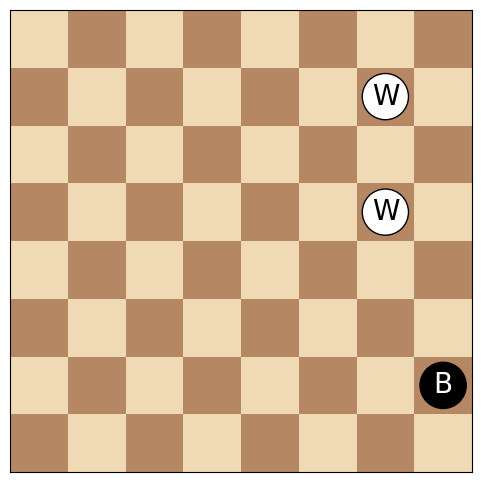

Movimiento de negro desde (6, 7) a (7, 6) con prioridad 1

Turno 150 del jugador: blanco


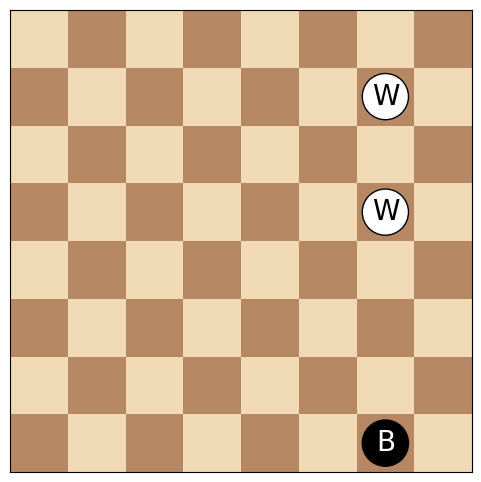

Movimiento de blanco desde (1, 6) a (2, 7) con prioridad 1

Turno 151 del jugador: negro


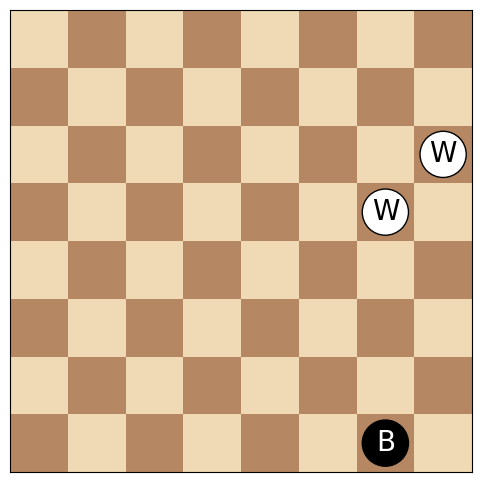

Movimiento de negro desde (7, 6) a (6, 7) con prioridad 6

Turno 152 del jugador: blanco


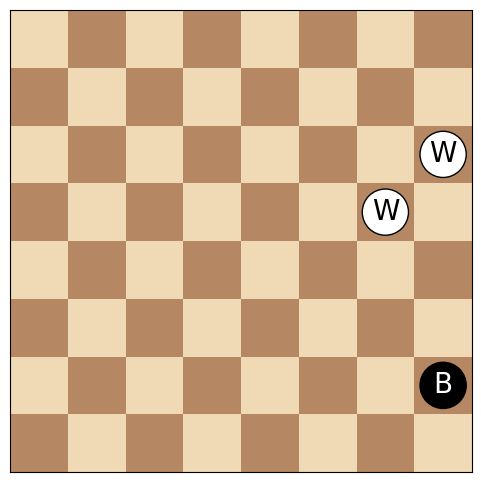

Movimiento de blanco desde (3, 6) a (4, 7) con prioridad 3

Turno 153 del jugador: negro


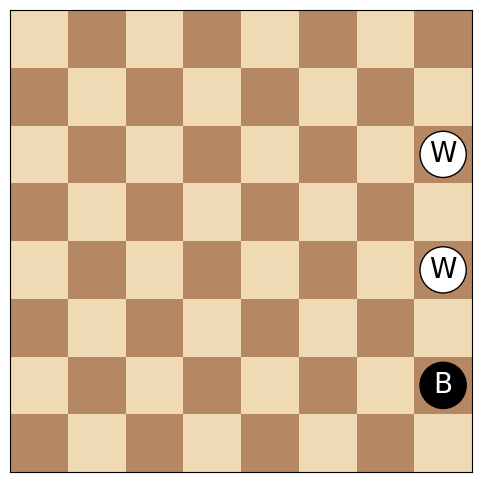

Movimiento de negro desde (6, 7) a (7, 6) con prioridad 1

Turno 154 del jugador: blanco


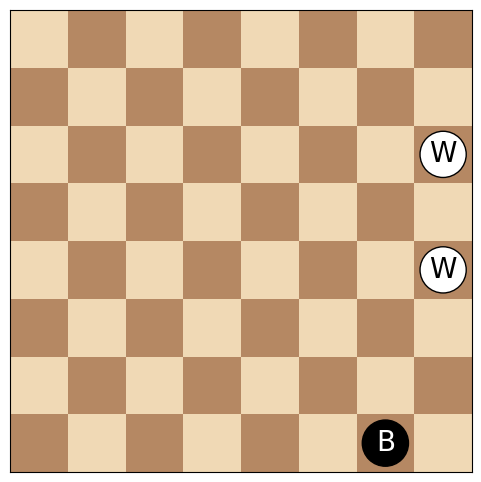

Movimiento de blanco desde (4, 7) a (5, 6) con prioridad 3

Turno 155 del jugador: negro


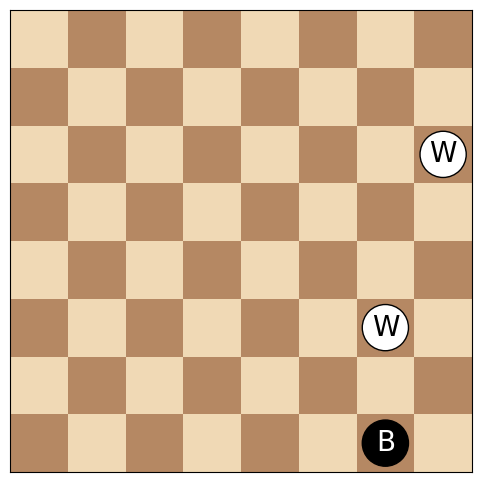

Movimiento de negro desde (7, 6) a (6, 5) con prioridad 8

Turno 156 del jugador: blanco


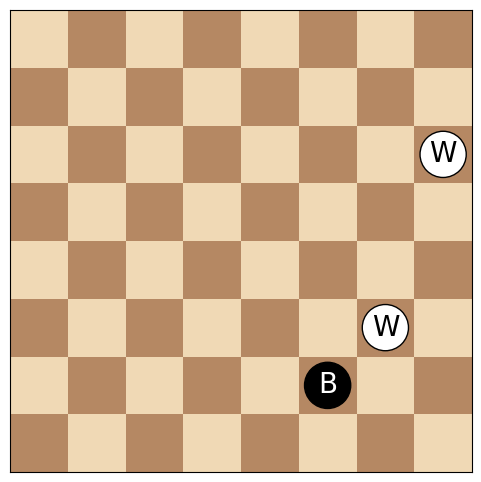

Movimiento de blanco desde (5, 6) a (7, 4) con prioridad 2

Turno 157 del jugador: negro


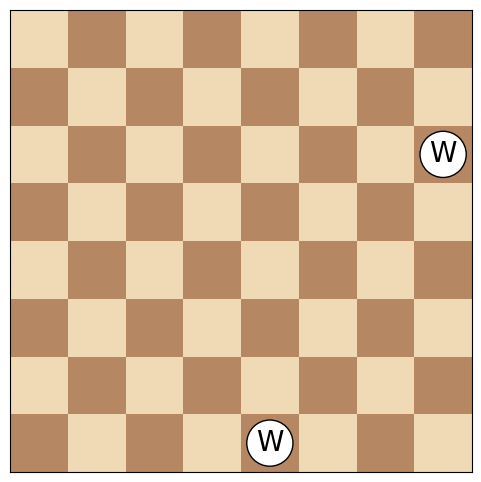

No hay movimientos posibles para el jugador negro
Juego terminado. Gana el jugador negro


In [ ]:
game = CheckersGame()
id_move = -1
# for _ in range(1000):
while True:
    id_move += 1
    print(f"\nTurno {id_move} del jugador:", 'blanco' if game.player_turn == 1 else 'negro')
    game.print_board()

    move = find_best_move(game)

    if move is None:
        print("Juego terminado. Gana el jugador", 'negro' if game.player_turn == -1 else 'blanco')
        break

    from_row, from_col = move['from']
    to_row, to_col = move['to']

    print(f"Movimiento de {('blanco' if game.player_turn == 1 else 'negro')} desde ({from_row}, {from_col}) a ({to_row}, {to_col}) con prioridad {move['priority']}")

    # Actualizar el tablero
    game.board[to_row][to_col] = game.board[from_row][from_col]
    game.board[from_row][from_col] = 0

    # Verificar si se realizó una captura
    if abs(to_row - from_row) == 2:
        mid_row = (from_row + to_row) // 2
        mid_col = (from_col + to_col) // 2
        game.board[mid_row][mid_col] = 0  # Eliminar la ficha capturada

    # Verificar si se corona una dama
    if (game.player_turn == 1 and to_row == 0) or (game.player_turn == -1 and to_row == game.size - 1):
        game.board[to_row][to_col] = 2 * game.player_turn  # Convertir en dama

    # Cambiar de turno
    game.player_turn *= -1
